# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import json
from torch import save, load

# Dataset

In [3]:
seed = 2133330296#randint(0, 4294967295)
print(seed)

2133330296


In [4]:
DIR = 'churn'

In [5]:
df = pd.read_csv(f'data/{DIR}/customer_churn_telecom_services.csv', header=0)
print('Nº de instâncias:', len(df))
df.head()

Nº de instâncias: 7043


gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [6]:
# Quantiades de cada valor único por coluna
nmrc_cols = []
cat_cols = []

for col in df.drop(columns=['Churn']).columns:
    unique_values = df[col].value_counts()
    if(len(unique_values) <= 4):
        print(unique_values, '\n')
        #df[col] = df[col].astype('category')
        cat_cols.append(col)
    else:
        nmrc_cols.append(col)

gender
Male      3555
Female    3488
Name: count, dtype: int64 

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet ser

In [7]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Alterando colunas categóricas binárias para int

#df_train1['gender'] = df_train1['gender'].apply(lambda x: 0 if x=='Male' else 1)

rdict = {'gender': {'Male': 0, 'Female': 1}, 
         'Partner': {'No': 0, 'Yes': 1},
         'Dependents': {'No': 0, 'Yes': 1},
         'PhoneService': {'No': 0, 'Yes': 1},
         'PaperlessBilling': {'No': 0, 'Yes': 1},
         'Churn': {'No': 0, 'Yes': 1},
         }

# Alterando colunas que são parcialmente dummy
# Exp.: OnlineSecurity: ("No internet service", "No", "Yes") -> (0, 1, 2)

rdict['MultipleLines'] = {'No phone service': 0, 'No': 1, 'Yes': 2}

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
        'StreamingTV', 'StreamingMovies']

for col in cols:
    rdict[col] = {'No internet service': 0, 'No': 1, 'Yes': 2}

# Alterando colunas não-dummy

rdict['InternetService'] = {'No': 0, 'DSL': 1, 'Fiber optic': 2}

rdict['Contract'] = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

rdict['PaymentMethod'] = {'Credit card (automatic)': 0, 'Bank transfer (automatic)': 1,
                          'Mailed check': 2, 'Electronic check': 3}

df = df.replace(rdict).rename(columns={'Churn': 'target'})
df.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_7392\3383695723.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(rdict).rename(columns={'Churn': 'target'})


gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        1           0       1             0   
1       0              0        0           0      34             1   
2       0              0        0           0       2             1   
3       0              0        0           0      45             0   
4       1              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              0                1               1             2   
1              1                1               2             1   
2              1                1               2             2   
3              0                1               2             1   
4              1                2               1             1   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 1            1            1                1         0   
1                 2            1            1                1         1   
2                 1            1            1                1         0   
3                 2            2            1                1         1   
4                 1            1            1                1         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  target  
0                 1              3           29.85         29.85       0  
1                 0              2           56.95       1889.50       0  
2                 1              2           53.85        108.15       1  
3                 0              1           42.30       1840.75       0  
4                 1              3           70.70        151.65       1

In [8]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5
cols = df.drop(columns=['target']).columns

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [9]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
#Xa_test_norm = scaler.transform(Xa_test)

In [10]:
# Normalização no conjunto de treinamento
scaler1 = MinMaxScaler()

Xb_train_norm = Xb_train.copy()
Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)

# Normalização nos conjuntos de validação e teste, com base nos dados de treinamento
Xb_test_norm = Xb_test.copy()
Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])

Xa_test_norm = Xa_test.copy()
Xa_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xa_test_norm.loc[:,nmrc_cols])

Xb_train_norm.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_7392\62727071.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75       0.76388889 0.875      ... 0.90277778 0.23611111 0.04166667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)
C:\Users\pedro\AppData\Local\Temp\ipykernel_7392\62727071.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31944444 0.06944444 0.23611111 ... 0.98611111 0.33333333 0.51388889]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])
C:\Users\pedro\AppData\Local\Temp\ipykernel_7392\62727071.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated an

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
1819       0              0        1           1  0.750000             1   
1364       0              1        0           0  0.763889             1   
1898       1              0        1           0  0.875000             1   
2046       0              0        0           0  0.138889             1   
2082       0              0        1           1  0.250000             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
1819              2                1               2             2   
1364              2                2               2             2   
1898              1                2               2             1   
2046              1                2               2             1   
2082              1                2               1             1   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
1819                 1            2            1                1         2   
1364                 2            2            2                2         0   
1898                 2            1            1                1         1   
2046                 2            1            2                2         1   
2082                 1            2            1                2         0   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  
1819                 1              0        0.472347      0.410683  
1364                 1              3        0.979073      0.734910  
1898                 1              0        0.626806      0.601568  
2046                 1              3        0.803687      0.122622  
2082                 1              3        0.671151      0.184403

In [11]:
# Balanceamento no conjunto de treinamento
o_sampler = RandomOverSampler(random_state=seed)

yb_train_norm = yb_train.copy()
Xb_train, yb_train = o_sampler.fit_resample(Xb_train, yb_train)
Xb_train_norm, yb_train_norm = o_sampler.fit_resample(Xb_train_norm, yb_train_norm)

# Base Models

In [12]:
performs = {}
models_error = pd.DataFrame()
models = []

In [13]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [14]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.9972
Recall:           0.9994
Precision:        0.9949
F1:               0.9972
AUROC:            0.9999
AUPR:             0.9999
1-maxProb média:  0.0028
1-maxProb dp:     0.0217

[Testing]

Accuracy:         0.7286
Recall:           0.4780
Precision:        0.4579
F1:               0.4678
AUROC:            0.6461
AUPR:             0.3496
1-maxProb média:  0.0015
1-maxProb dp:     0.0204


In [16]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0    1.0
1    0.0
2    1.0
3    1.0
4    0.0

In [17]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [18]:
sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'}


In [19]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.7741
Recall:           0.8103
Precision:        0.7557
F1:               0.7820
AUROC:            0.8507
AUPR:             0.8278
1-maxProb média:  0.2424
1-maxProb dp:     0.1493

[Testing]

Accuracy:         0.7473
Recall:           0.7984
Precision:        0.4960
F1:               0.6118
AUROC:            0.8414
AUPR:             0.6361
1-maxProb média:  0.2316
1-maxProb dp:     0.1617


### Logistic Regression

In [20]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [21]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.7795
Recall:           0.8154
Precision:        0.7608
F1:               0.7871
AUROC:            0.8531
AUPR:             0.8298
1-maxProb média:  0.2261
1-maxProb dp:     0.1368

[Testing]

Accuracy:         0.7485
Recall:           0.7984
Precision:        0.4975
F1:               0.6130
AUROC:            0.8423
AUPR:             0.6338
1-maxProb média:  0.2194
1-maxProb dp:     0.1456


### K-Nearest Neighbors

(KNN)

In [22]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [23]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0008
1-maxProb dp:     0.0168

[Testing]

Accuracy:         0.6974
Recall:           0.6407
Precision:        0.4287
F1:               0.5137
AUROC:            0.7423
AUPR:             0.4387
1-maxProb média:  0.1187
1-maxProb dp:     0.1654


### Support Vector Machine - Linear
(SVM)

In [24]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 1}


In [25]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.7685
Recall:           0.8159
Precision:        0.7452
F1:               0.7790
AUROC:            0.8523
AUPR:             0.8261
1-maxProb média:  0.2251
1-maxProb dp:     0.1278

[Testing]

Accuracy:         0.7355
Recall:           0.8114
Precision:        0.4821
F1:               0.6048
AUROC:            0.8403
AUPR:             0.6327
1-maxProb média:  0.2193
1-maxProb dp:     0.1408


### Support Vector Machine - Polynomial
(SVM)

In [26]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 10, 'degree': 4, 'gamma': 'scale'}


In [27]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9054
Recall:           0.9385
Precision:        0.8803
F1:               0.9084
AUROC:            0.9497
AUPR:             0.9235
1-maxProb média:  0.1847
1-maxProb dp:     0.1107

[Testing]

Accuracy:         0.7331
Recall:           0.6520
Precision:        0.4746
F1:               0.5493
AUROC:            0.7639
AUPR:             0.5035
1-maxProb média:  0.1781
1-maxProb dp:     0.1387


### Support Vector Machine - RBF
(SVM)

In [28]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 10, 'gamma': 'scale'}


In [29]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.8608
Recall:           0.9260
Precision:        0.8192
F1:               0.8693
AUROC:            0.9321
AUPR:             0.9022
1-maxProb média:  0.1724
1-maxProb dp:     0.1119

[Testing]

Accuracy:         0.7387
Recall:           0.7463
Precision:        0.4847
F1:               0.5877
AUROC:            0.8062
AUPR:             0.5498
1-maxProb média:  0.1758
1-maxProb dp:     0.1363


### Multi-Layer Perceptron
(MLP)

In [30]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}


In [31]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9780
Recall:           0.9876
Precision:        0.9690
F1:               0.9782
AUROC:            0.9986
AUPR:             0.9986
1-maxProb média:  0.0339
1-maxProb dp:     0.0903

[Testing]

Accuracy:         0.7432
Recall:           0.5398
Precision:        0.4868
F1:               0.5120
AUROC:            0.7672
AUPR:             0.4785
1-maxProb média:  0.0636
1-maxProb dp:     0.1243


### Kolmogorov-Arnold Network
(KAN)

In [32]:
kan_cv = 0#int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [33]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]
INP_SIZE = Xb_train_norm.shape[1]
kan_params = {'width': [[INP_SIZE,2,2,2], [INP_SIZE,3,2], [INP_SIZE,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open(f'kan_params/{DIR}.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/{DIR}.pkl')
    save(kanet.state_dict(), f'kan_params/{DIR}.pt')
else:
    with open(f'kan_params/{DIR}.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load(f'kan_params/{DIR}.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[19, 0], [2, 0], [2, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [34]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         0.7922
Recall:           0.8018
Precision:        0.7867
F1:               0.7942
AUROC:            0.8552
AUPR:             0.8255
1-maxProb média:  0.2426
1-maxProb dp:     0.0955

[Testing]

Accuracy:         0.7611
Recall:           0.7561
Precision:        0.5144
F1:               0.6122
AUROC:            0.8236
AUPR:             0.5984
1-maxProb média:  0.2395
1-maxProb dp:     0.1005


### Random Forest

In [35]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [36]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9992
Recall:           1.0000
Precision:        0.9983
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0609
1-maxProb dp:     0.0842

[Testing]

Accuracy:         0.7822
Recall:           0.6000
Precision:        0.5591
F1:               0.5788
AUROC:            0.8171
AUPR:             0.5820
1-maxProb média:  0.1949
1-maxProb dp:     0.1567


### Gradient Boosting

In [37]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 150}


In [38]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0009
1-maxProb dp:     0.0167

[Testing]

Accuracy:         0.7744
Recall:           0.5154
Precision:        0.5513
F1:               0.5328
AUROC:            0.8063
AUPR:             0.5779
1-maxProb média:  0.0414
1-maxProb dp:     0.1001


### AdaBoost

In [39]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'learning_rate': 1, 'n_estimators': 150}


In [40]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8077
Recall:           0.8413
Precision:        0.7884
F1:               0.8140
AUROC:            0.8842
AUPR:             0.8651
1-maxProb média:  0.4954
1-maxProb dp:     0.0088

[Testing]

Accuracy:         0.7562
Recall:           0.7707
Precision:        0.5075
F1:               0.6120
AUROC:            0.8324
AUPR:             0.6130
1-maxProb média:  0.4948
1-maxProb dp:     0.0093


### XGBoost

In [41]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 150}


In [42]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         0.9986
Recall:           1.0000
Precision:        0.9972
F1:               0.9986
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0313
1-maxProb dp:     0.0438

[Testing]

Accuracy:         0.7748
Recall:           0.6065
Precision:        0.5437
F1:               0.5734
AUROC:            0.8112
AUPR:             0.5669
1-maxProb média:  0.0994
1-maxProb dp:     0.1318


## Análise de Correlações

In [43]:
groups = {}
model_names = list(performs.keys())

In [44]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


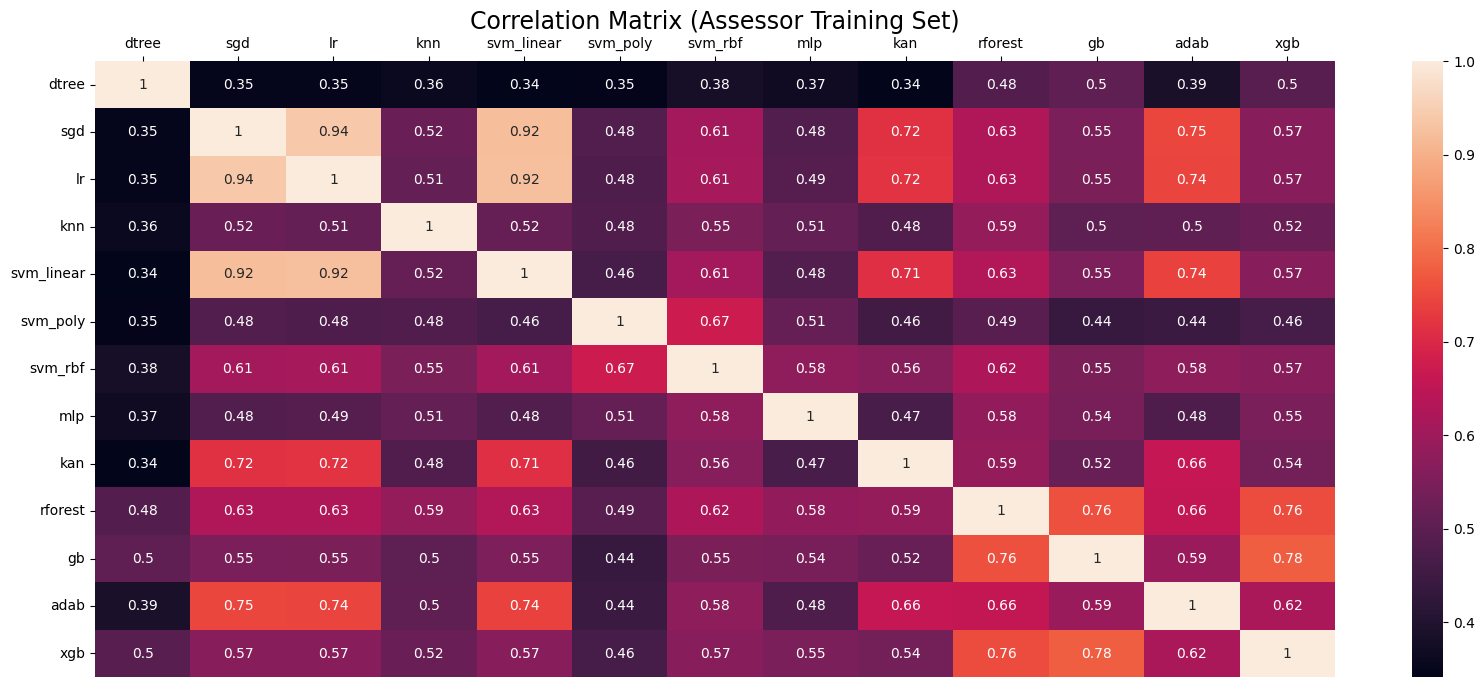

            corr
count  78.000000
mean    0.557495
std     0.129782
min     0.341243
25%     0.481144
50%     0.546214
75%     0.616927
max     0.938501


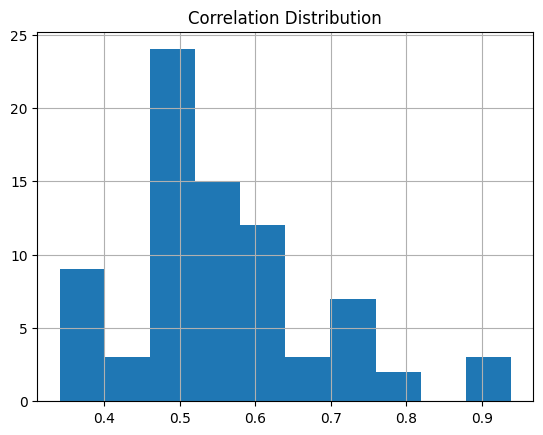

[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [45]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, DIR)

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [46]:
MIN_SCORE = 0.65 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.65


[['dtree'],
 ['svm_poly', 'svm_rbf'],
 ['lr', 'adab', 'kan', 'svm_linear', 'sgd'],
 ['adab', 'rforest'],
 ['xgb', 'rforest', 'gb'],
 ['mlp'],
 ['knn']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [47]:
Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0    1.0  0.816066  0.840734  1.000000    0.837717  0.907080  0.903634   
1    0.0  0.502942  0.506229  0.000000    0.569663  0.525230  0.544435   
2    1.0  0.568665  0.582332  1.000000    0.546538  0.876562  0.894867   
3    1.0  0.827625  0.859563  0.762667    0.852293  0.834433  0.888112   
4    0.0  0.490065  0.506757  0.000000    0.563256  0.182115  0.184304   

        mlp       kan  rforest        gb      adab       xgb  
0  0.710727  0.804435     0.42  0.784064  0.502135  0.542966  
1  0.000883  0.591973     0.32  0.005767  0.499038  0.601519  
2  1.000000  0.778475     0.88  0.999986  0.502213  0.997659  
3  0.989154  0.770610     0.78  0.840228  0.502755  0.811739  
4  0.000026  0.353119     0.14  0.000121  0.499719  0.011263

In [48]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0    0.0  0.141922  0.101620  0.000000    0.117275  0.134259  0.156307   
1    1.0  0.121427  0.111948  0.000000    0.128655  0.168696  0.185578   
2    1.0  0.823291  0.841404  1.000000    0.844831  0.999517  0.965199   
3    0.0  0.133640  0.124236  0.252403    0.161239  0.219065  0.171739   
4    0.0  0.216827  0.178295  0.000000    0.177934  0.168973  0.154507   

        mlp       kan  rforest        gb      adab       xgb  
0  0.883674  0.182760     0.02  0.000029  0.493983  0.006569  
1  0.363394  0.238028     0.34  0.981957  0.496981  0.472621  
2  0.987933  0.823441     0.92  0.999988  0.502688  0.977660  
3  0.000593  0.175512     0.08  0.004287  0.497029  0.034872  
4  0.000400  0.202865     0.00  0.000002  0.496568  0.010851

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

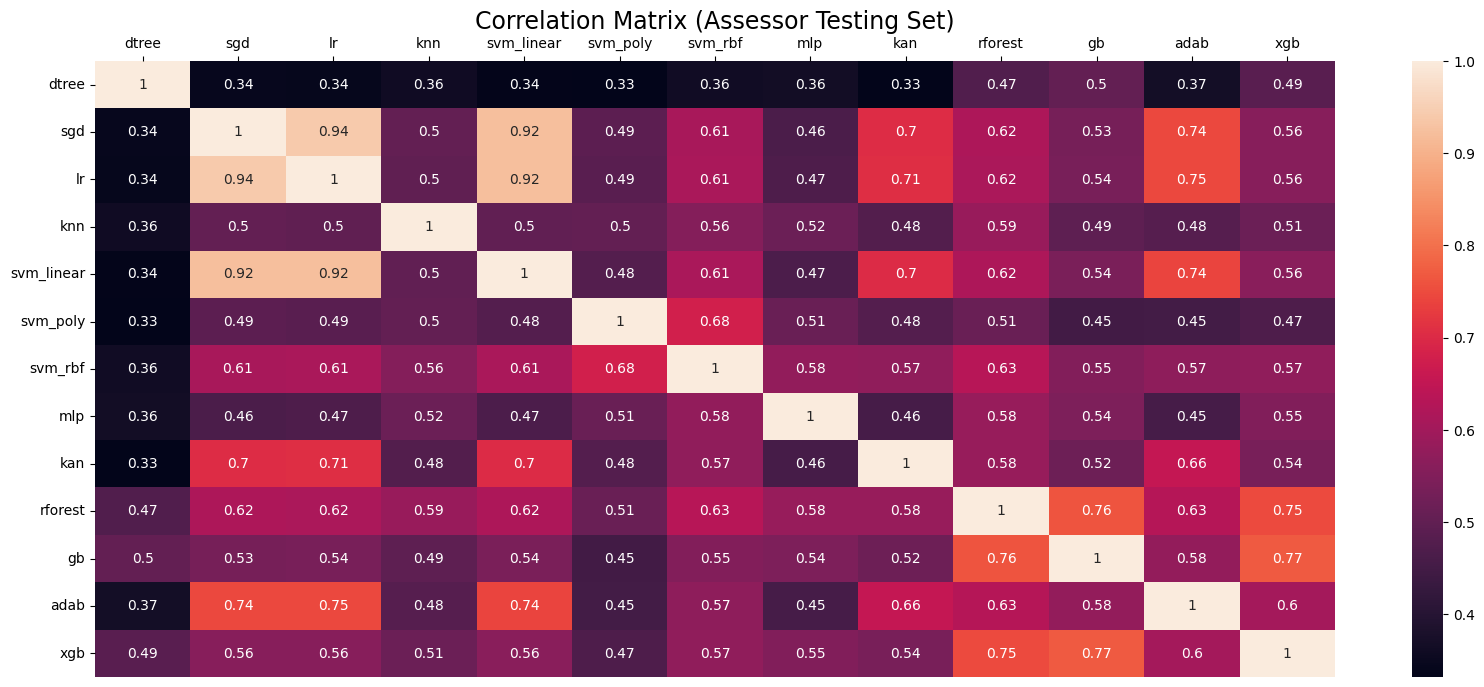

count    78.000000
mean      0.553983
std       0.130472
min       0.332007
25%       0.478896
50%       0.538026
75%       0.612333
max       0.940438
Name: corr, dtype: float64


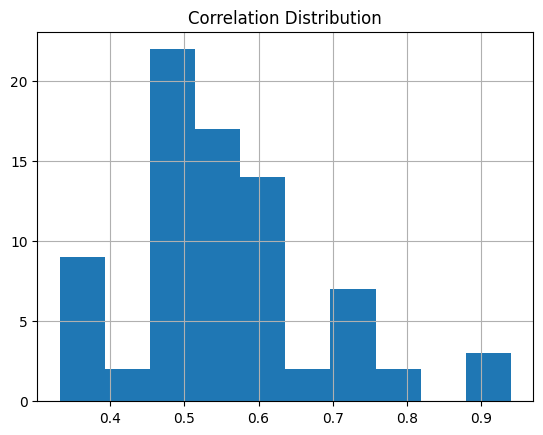

[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [49]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [50]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['dtree'],
 ['lr', 'adab', 'kan', 'svm_linear', 'sgd'],
 ['svm_poly', 'svm_rbf'],
 ['xgb', 'rforest', 'gb'],
 ['mlp'],
 ['knn']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0001
NMSE: 0.0110
MAE: 0.0088
NMSE: 0.0072
Desvio Padrão: 0.0105


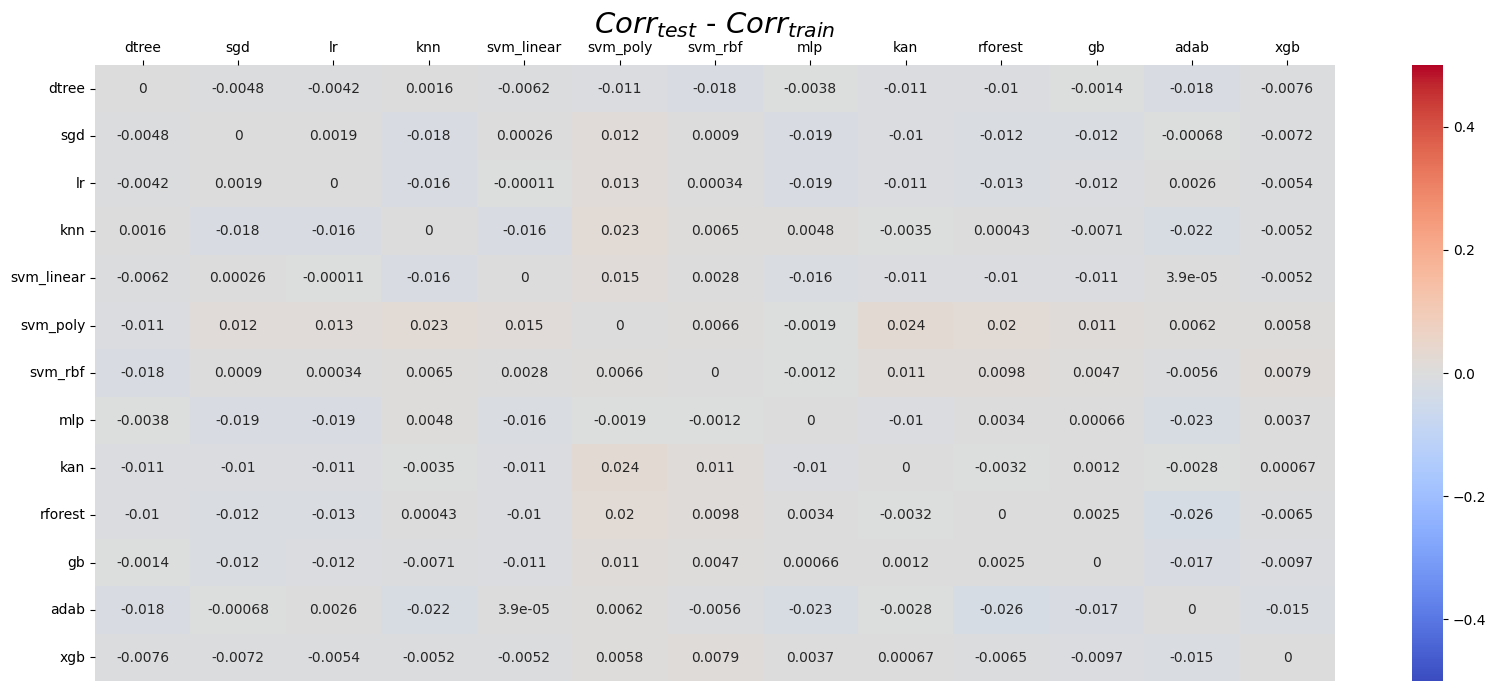

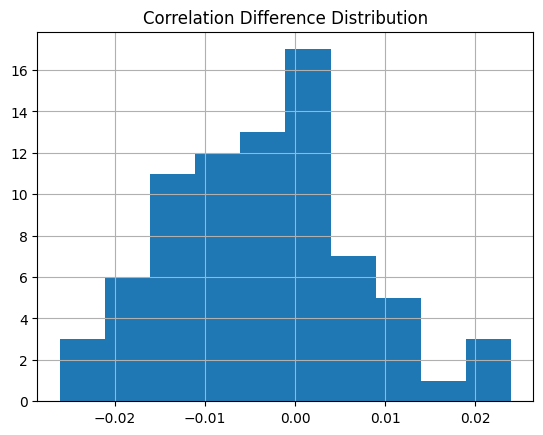

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [51]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

### Regressor Chain
(RC)

In [52]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.6s
[Chain] .................. (2 of 13) Processing order 1, total=   0.9s
[Chain] .................. (3 of 13) Processing order 2, total=   1.1s
[Chain] .................. (4 of 13) Processing order 3, total=   1.1s
[Chain] .................. (5 of 13) Processing order 4, total=   1.5s
[Chain] .................. (6 of 13) Processing order 5, total=   1.6s
[Chain] .................. (7 of 13) Processing order 6, total=   1.8s
[Chain] .................. (8 of 13) Processing order 7, total=   2.1s
[Chain] .................. (9 of 13) Processing order 8, total=   2.2s
[Chain] ................. (10 of 13) Processing order 9, total=   2.3s
[Chain] ................ (11 of 13) Processing order 10, total=   2.8s
[Chain] ................ (12 of 13) Processing order 11, total=   3.4s
[Chain] ................ (13 of 13) Processing order 12, total=   2.9s


In [53]:
mse_df = pd.DataFrame(columns=model_names, dtype=float)
#rmse_df = pd.DataFrame(columns=model_names, dtype=float)
nmse_df = pd.DataFrame(columns=model_names, dtype=float)
mae_df = pd.DataFrame(columns=model_names, dtype=float)
nmae_df = pd.DataFrame(columns=model_names, dtype=float)

In [54]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred)}''')

mse_df.loc['regchain',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['regchain',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['regchain',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['regchain',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0747
NMSE: 0.6998
MAE: 0.1886
NMAE: 0.7054577252806642


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain  0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   

           svm_rbf       mlp       kan   rforest        gb      adab       xgb  
regchain  0.062493  0.133824  0.037986  0.046162  0.126113  0.000037  0.089673

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

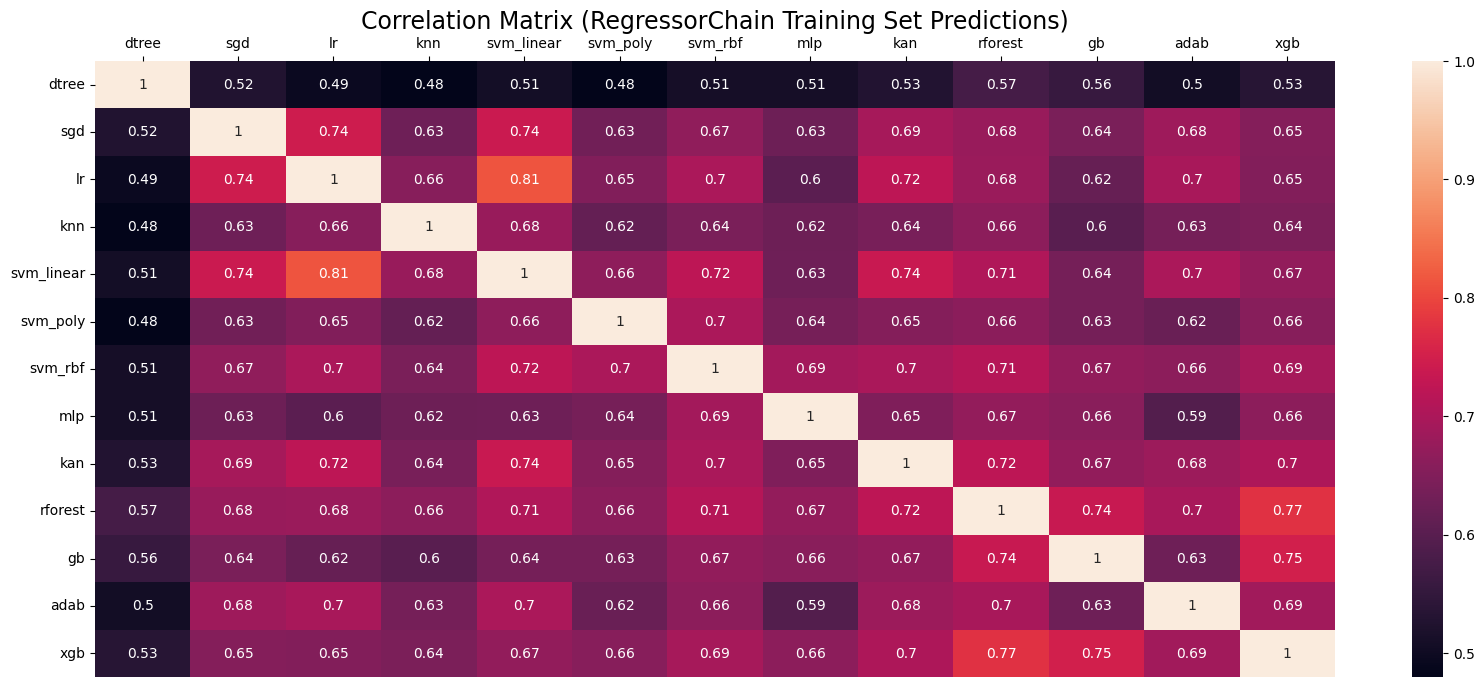

count    78.000000
mean      0.648092
std       0.069897
min       0.479636
25%       0.625629
50%       0.658492
75%       0.694795
max       0.813959
Name: corr, dtype: float64


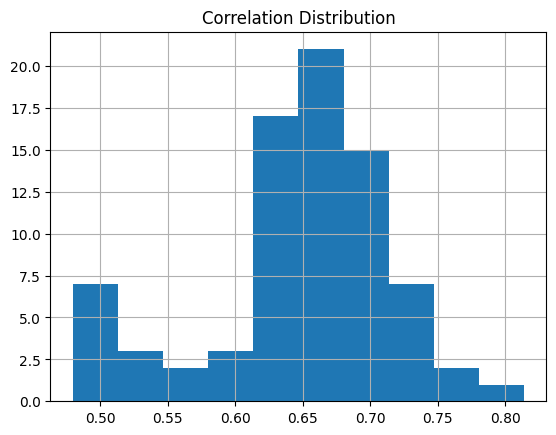

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [55]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('kendall') 

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [56]:
groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

[['dtree'],
 ['lr', 'knn', 'svm_linear', 'rforest'],
 ['lr', 'svm_rbf', 'adab', 'xgb', 'kan', 'rforest', 'svm_linear', 'sgd'],
 ['svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'svm_linear'],
 ['svm_rbf', 'xgb', 'kan', 'rforest', 'gb'],
 ['svm_rbf', 'xgb', 'rforest', 'mlp', 'gb']]

Conjunto de Teste:

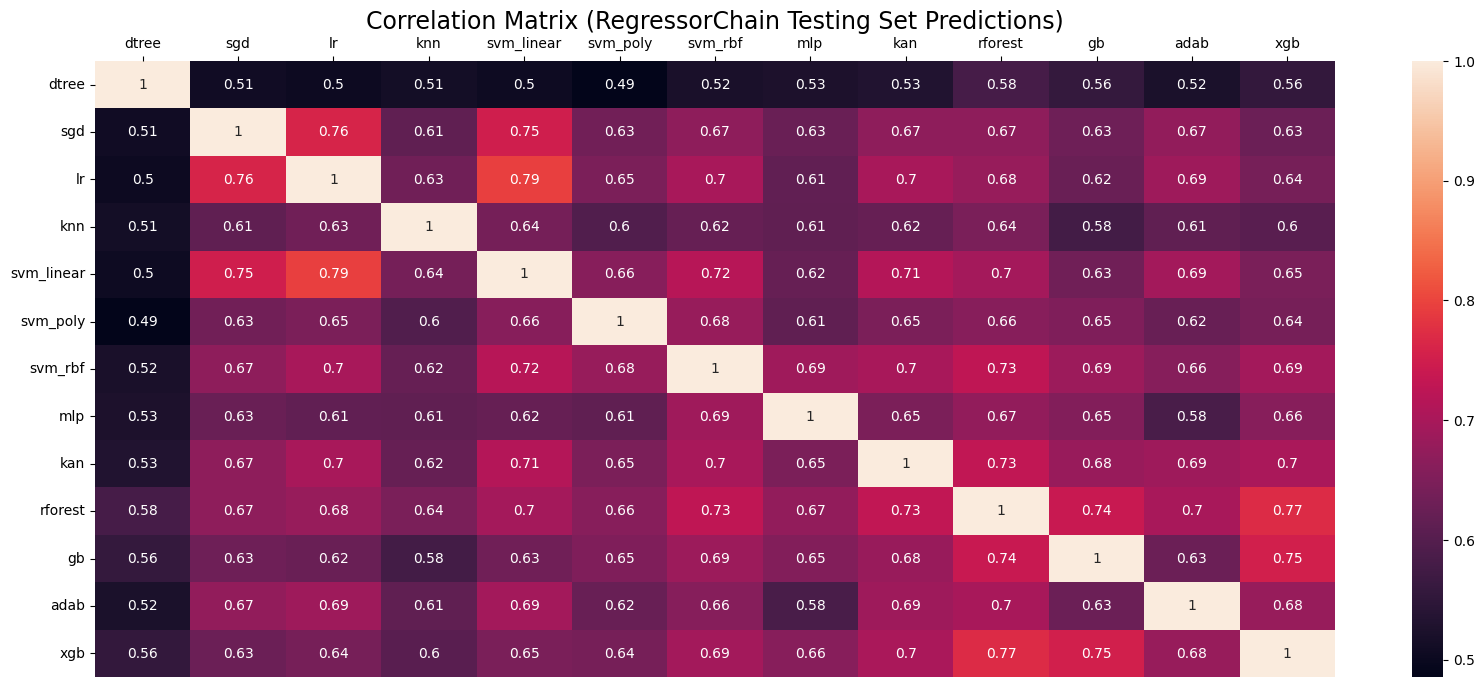

count    78.000000
mean      0.643964
std       0.067134
min       0.485543
25%       0.614069
50%       0.647030
75%       0.686977
max       0.794585
Name: corr, dtype: float64


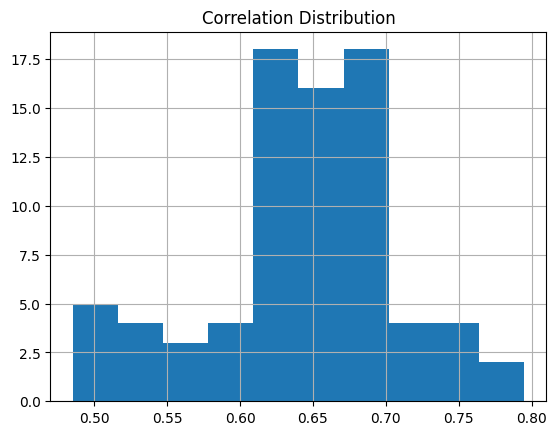

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [59]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [60]:
groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

[['dtree'],
 ['knn'],
 ['svm_poly', 'svm_linear', 'rforest', 'svm_rbf'],
 ['svm_poly', 'rforest', 'gb', 'svm_rbf'],
 ['lr', 'svm_rbf', 'adab', 'kan', 'rforest', 'svm_linear', 'sgd'],
 ['svm_rbf', 'xgb', 'adab', 'kan', 'rforest'],
 ['svm_rbf', 'xgb', 'kan', 'rforest', 'gb'],
 ['svm_rbf', 'xgb', 'rforest', 'mlp', 'gb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.3143
MAE: 0.5052
NMSE: 12.7006
NMAE: 4.5607


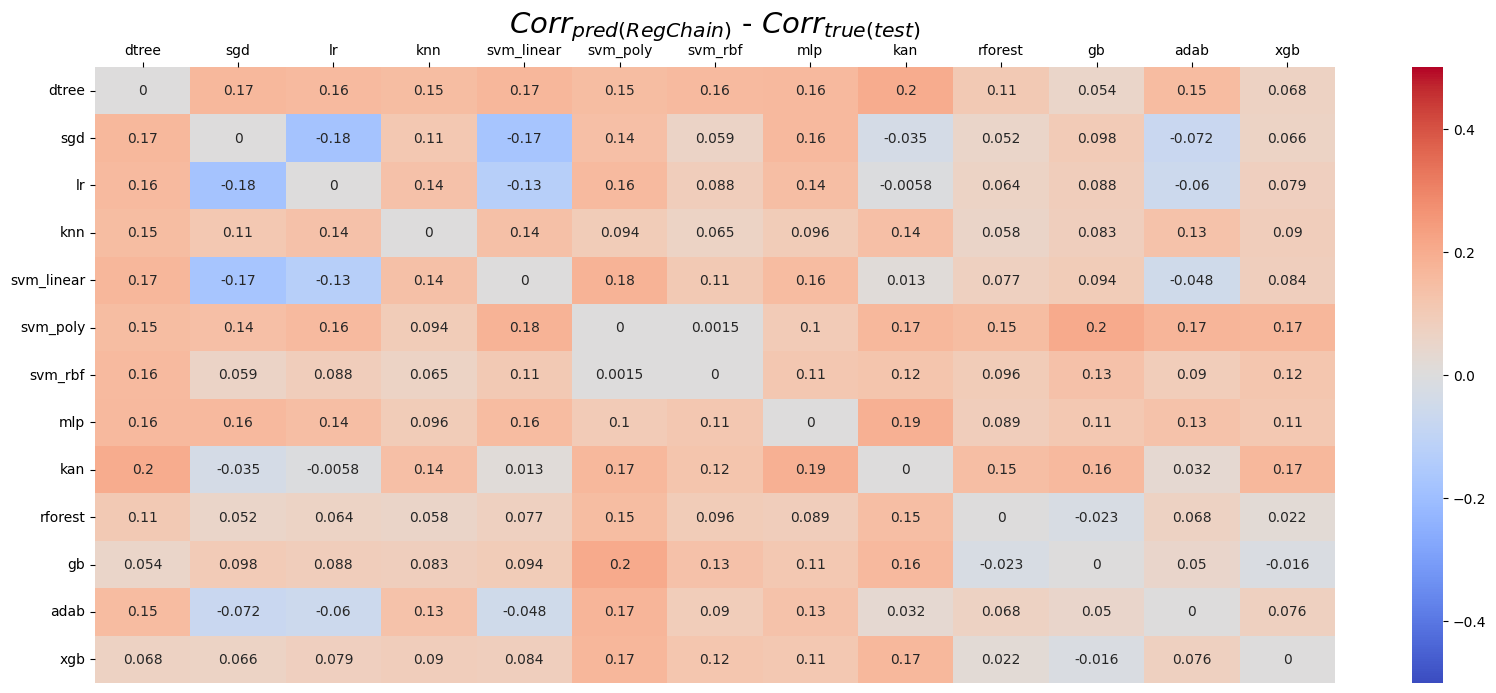

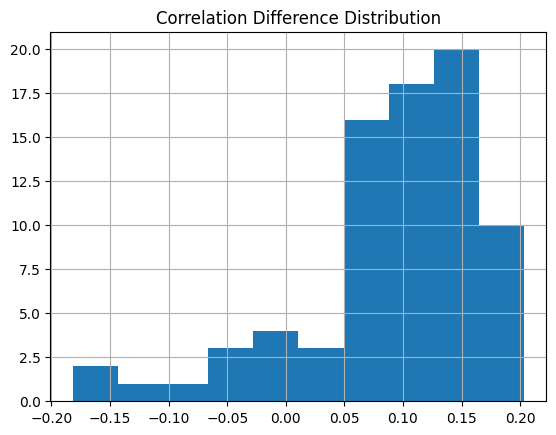

[Saved image "cmd_rc.eps"]
[Saved image "cd_rc.eps"]


In [61]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output Random Forest Regressor 

In [62]:
mrf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train)

In [63]:
ya_pred = mrf.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-rforest',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-rforest',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0766
NMSE: 0.7418
MAE: 0.1875
NMAE: 0.7207


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   
multi-rforest  0.178776  0.035354  0.041423  0.115596    0.039823  0.071328   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.062493  0.133824  0.037986  0.046162  0.126113  0.000037   
multi-rforest  0.064260  0.137920  0.039730  0.048880  0.130472  0.000072   

                    xgb  
regchain       0.089673  
multi-rforest  0.092237

#### Análise das correlações

Conjunto de Treinamento:

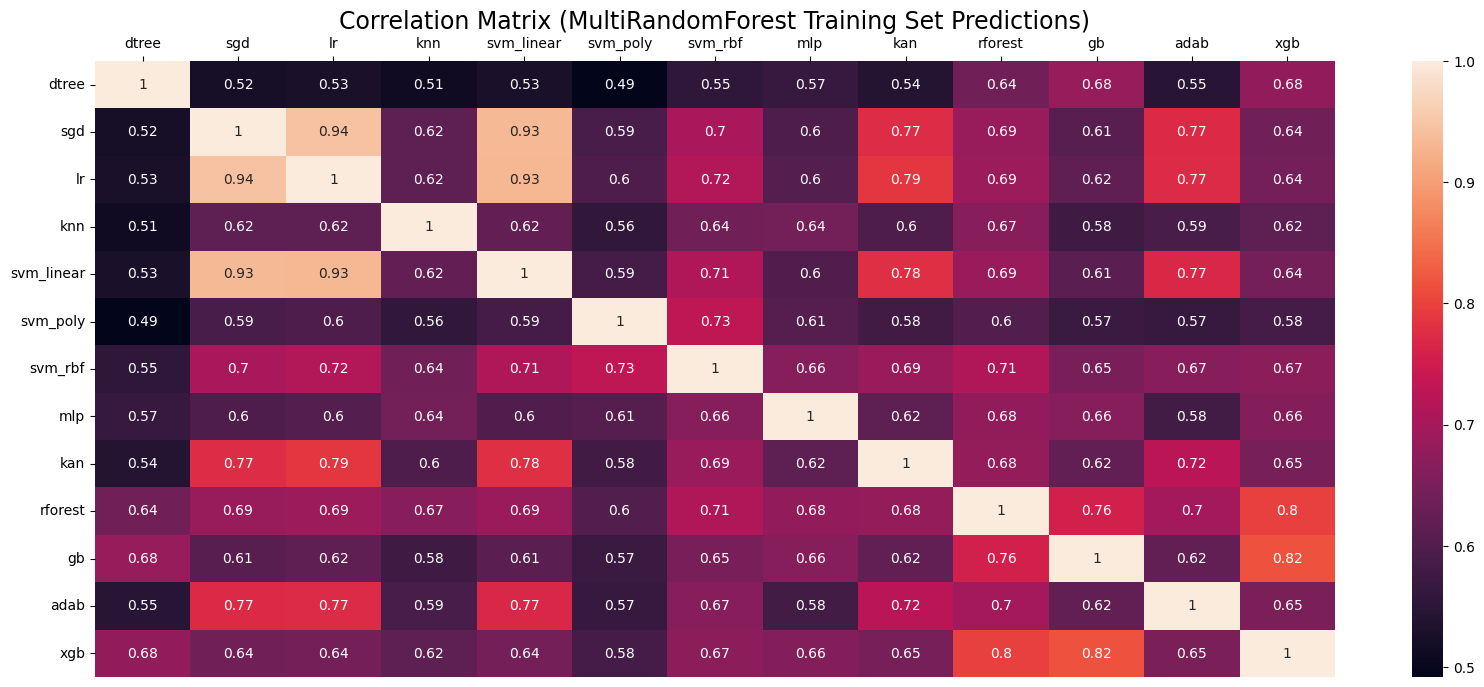

count    78.000000
mean      0.653865
std       0.091880
min       0.491802
25%       0.595286
50%       0.640084
75%       0.689453
max       0.944942
Name: corr, dtype: float64


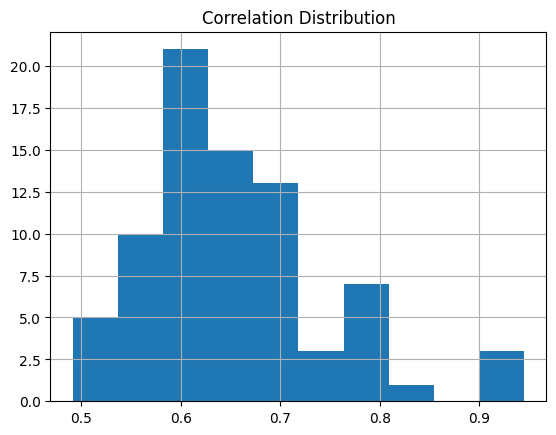

[Saved image "cm_mrftrain.eps"]
[Saved image "cd_mrftrain.eps"]


In [64]:
mrf_corrls = pd.DataFrame(mrf.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [65]:
groups['mrf_assessor_train'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_train']

[['dtree', 'gb', 'xgb'],
 ['knn', 'rforest'],
 ['mlp', 'rforest', 'gb', 'xgb'],
 ['lr', 'svm_rbf', 'adab', 'kan', 'rforest', 'svm_linear', 'sgd'],
 ['adab', 'rforest', 'svm_rbf', 'xgb'],
 ['mlp', 'rforest', 'svm_rbf', 'xgb'],
 ['svm_poly', 'svm_rbf']]

Conjunto de Teste:

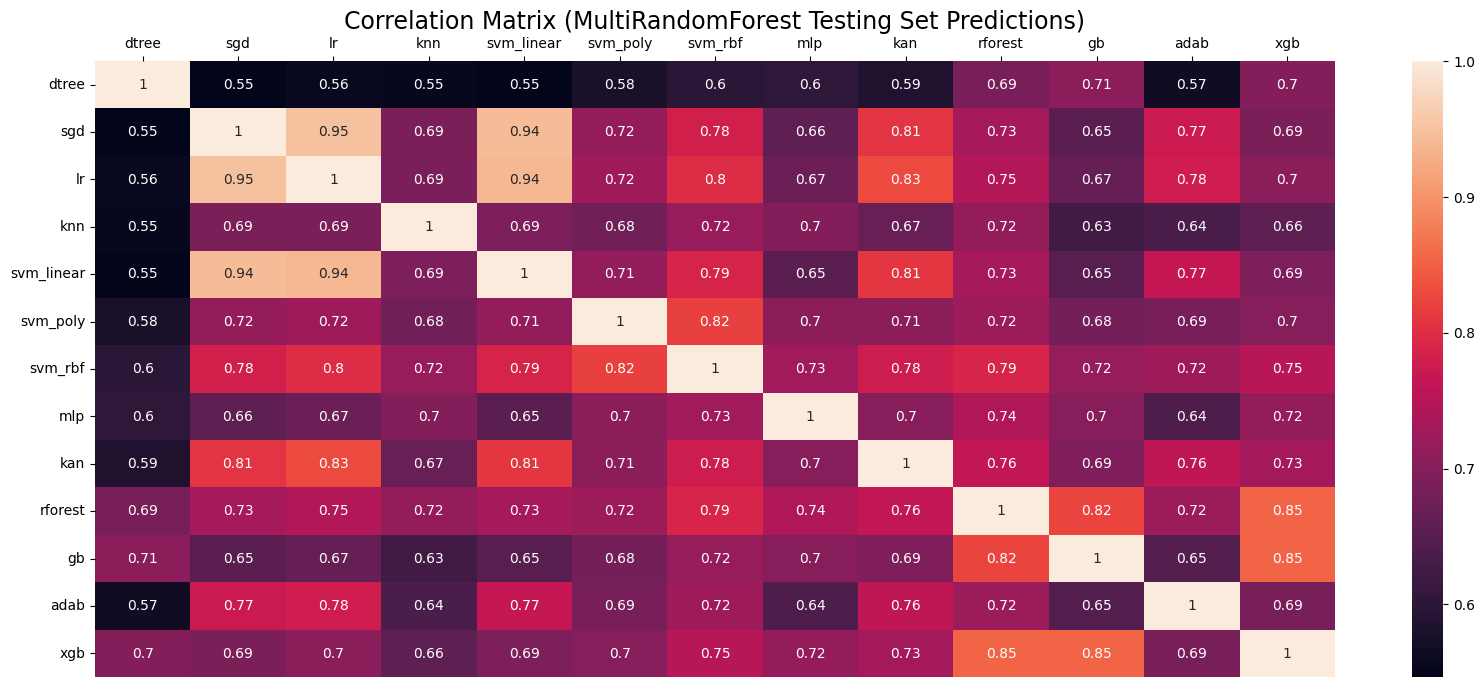

count    78.000000
mean      0.712697
std       0.084074
min       0.546570
25%       0.668616
50%       0.704913
75%       0.758017
max       0.950151
Name: corr, dtype: float64


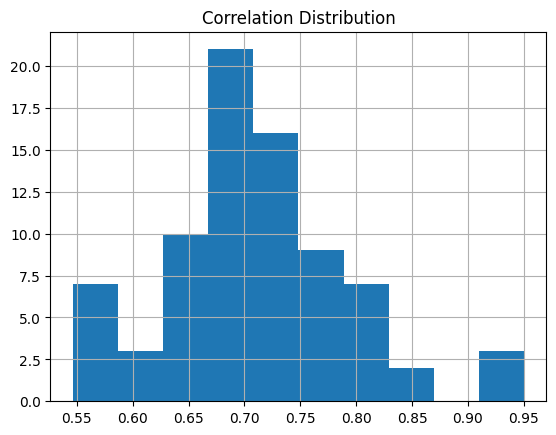

[Saved image "cm_mrftest.eps"]
[Saved image "cd_mrftest.eps"]


In [66]:
mrf_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [67]:
groups['mrf_assessor_test'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_test']

[['xgb', 'rforest', 'dtree', 'gb'],
 ['lr',
  'svm_poly',
  'svm_rbf',
  'adab',
  'xgb',
  'kan',
  'rforest',
  'svm_linear',
  'sgd'],
 ['lr',
  'svm_poly',
  'svm_rbf',
  'mlp',
  'xgb',
  'kan',
  'rforest',
  'svm_linear',
  'knn',
  'sgd'],
 ['lr',
  'svm_poly',
  'svm_rbf',
  'mlp',
  'xgb',
  'kan',
  'rforest',
  'svm_linear',
  'sgd',
  'gb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2524
MAE: 0.4418
NMSE: 10.2710
NMAE: 3.9858


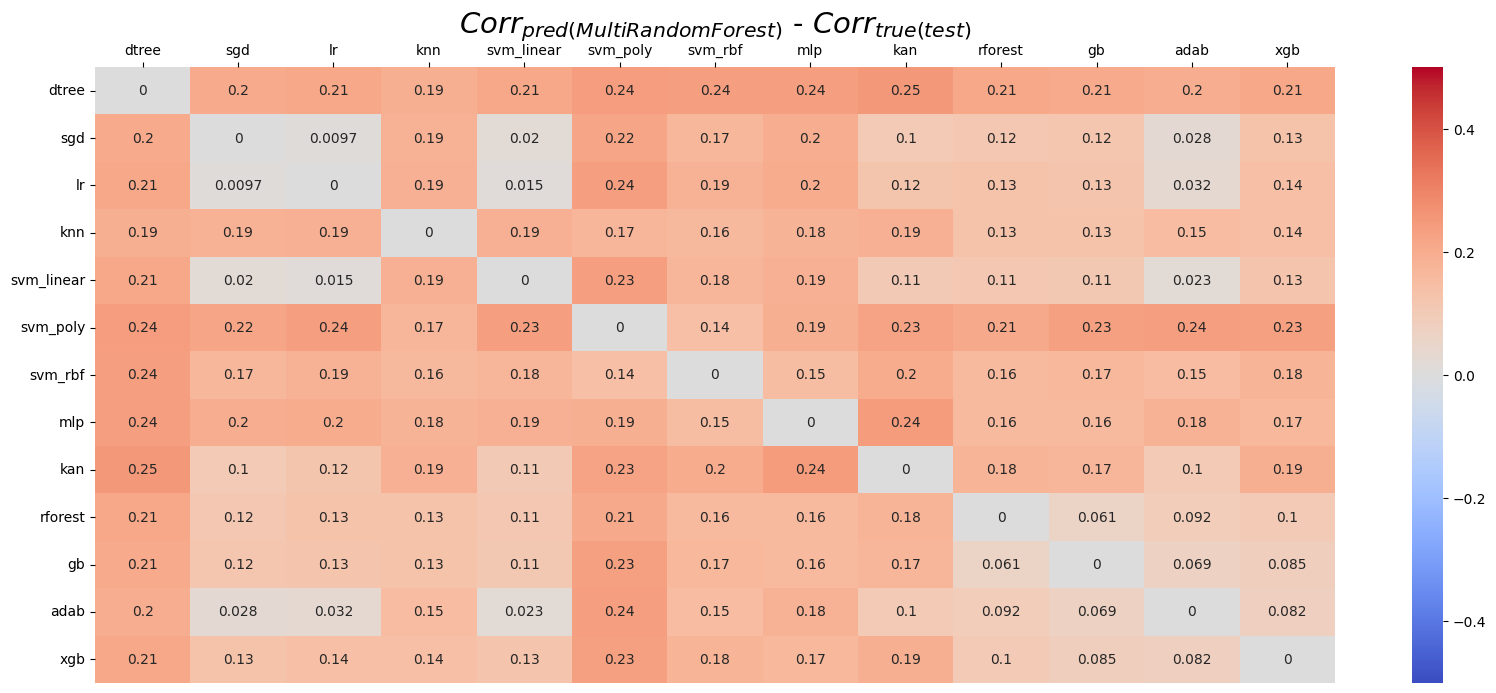

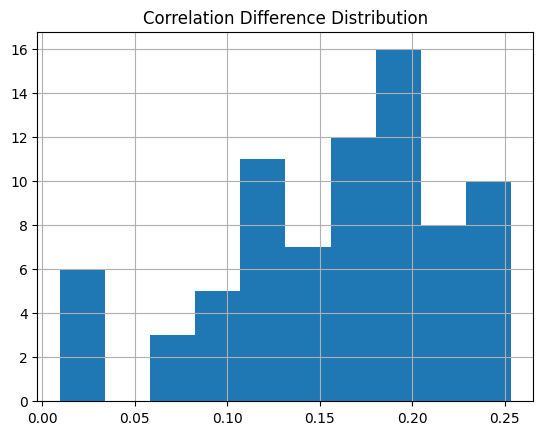

[Saved image "cmd_mrf.eps"]
[Saved image "cdd_mrf.eps"]


In [68]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mrf_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandomForest)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output SVR

In [69]:
from MSVR import MSVR

msvr = MSVR()
msvr.fit(np.asarray(Xb_test_norm), np.asarray(ya_train))

In [70]:
ya_pred = msvr.predict(Xa_test_norm)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-svr',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-svr',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-svr',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-svr',:] = nmae(ya_test, ya_pred, multioutput='raw_values')

MSE: 0.0729
MAE: 0.1946
NMSE: 0.7379
NMAE: 0.8034


#### Análise das correlações

Conjunto de Treinamento:

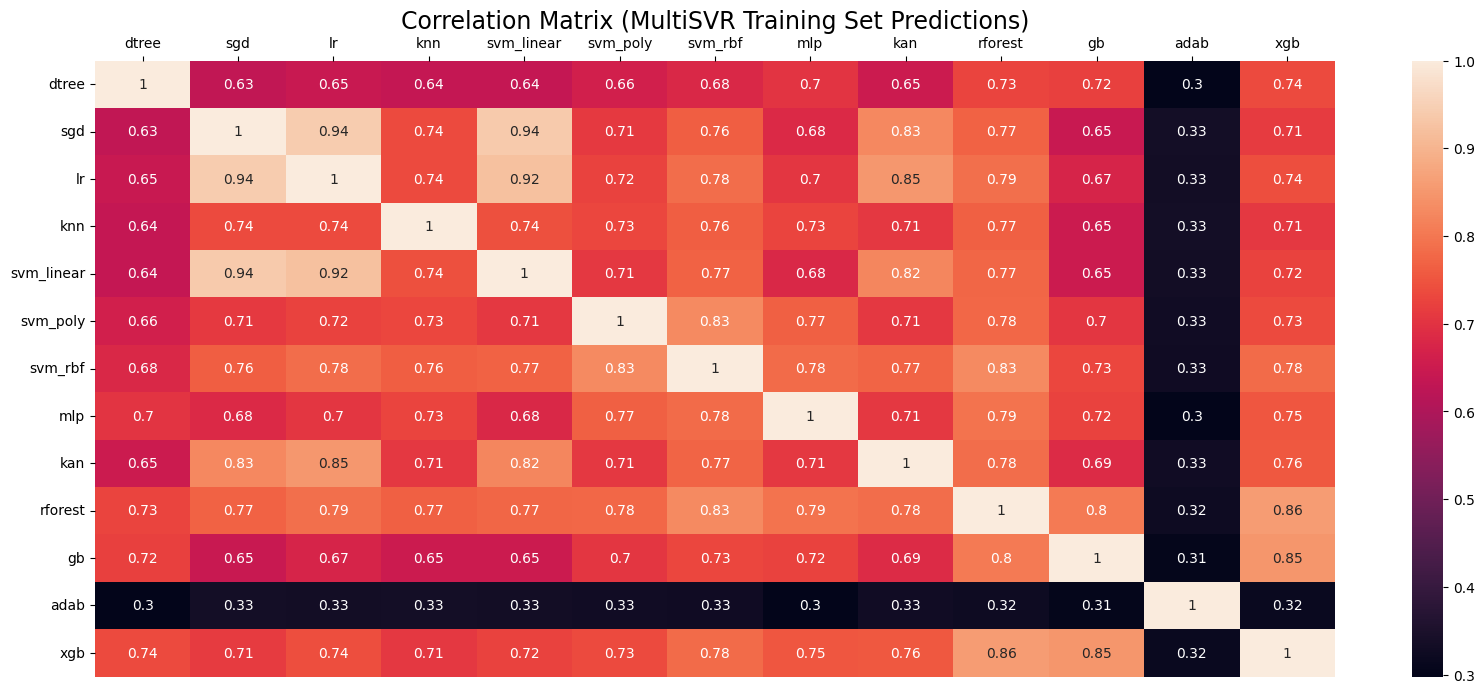

count    78.000000
mean      0.679298
std       0.166237
min       0.297700
25%       0.653494
50%       0.724216
75%       0.770505
max       0.941217
Name: corr, dtype: float64


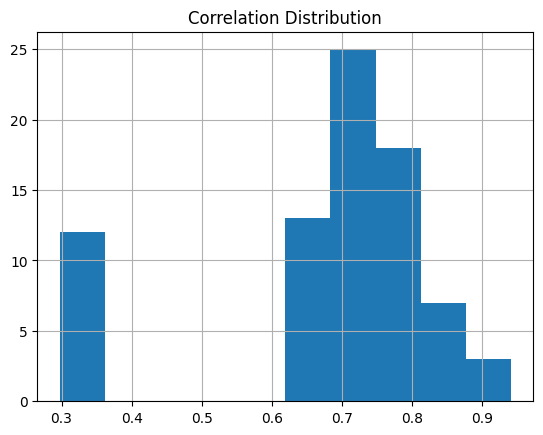

[Saved image "cm_msvrtrain.eps"]
[Saved image "cd_msvrtrain.eps"]


In [71]:
msvr_corrls = pd.DataFrame(msvr.predict(Xb_test_norm), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Training Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [72]:
groups['msvr_assessor_train'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_train']

[['dtree', 'svm_poly', 'svm_rbf', 'xgb', 'rforest', 'mlp', 'gb'],
 ['lr',
  'svm_poly',
  'svm_rbf',
  'mlp',
  'xgb',
  'kan',
  'rforest',
  'svm_linear',
  'knn',
  'sgd'],
 ['lr', 'svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'mlp', 'knn', 'gb'],
 ['adab']]

Conjunto de Teste:

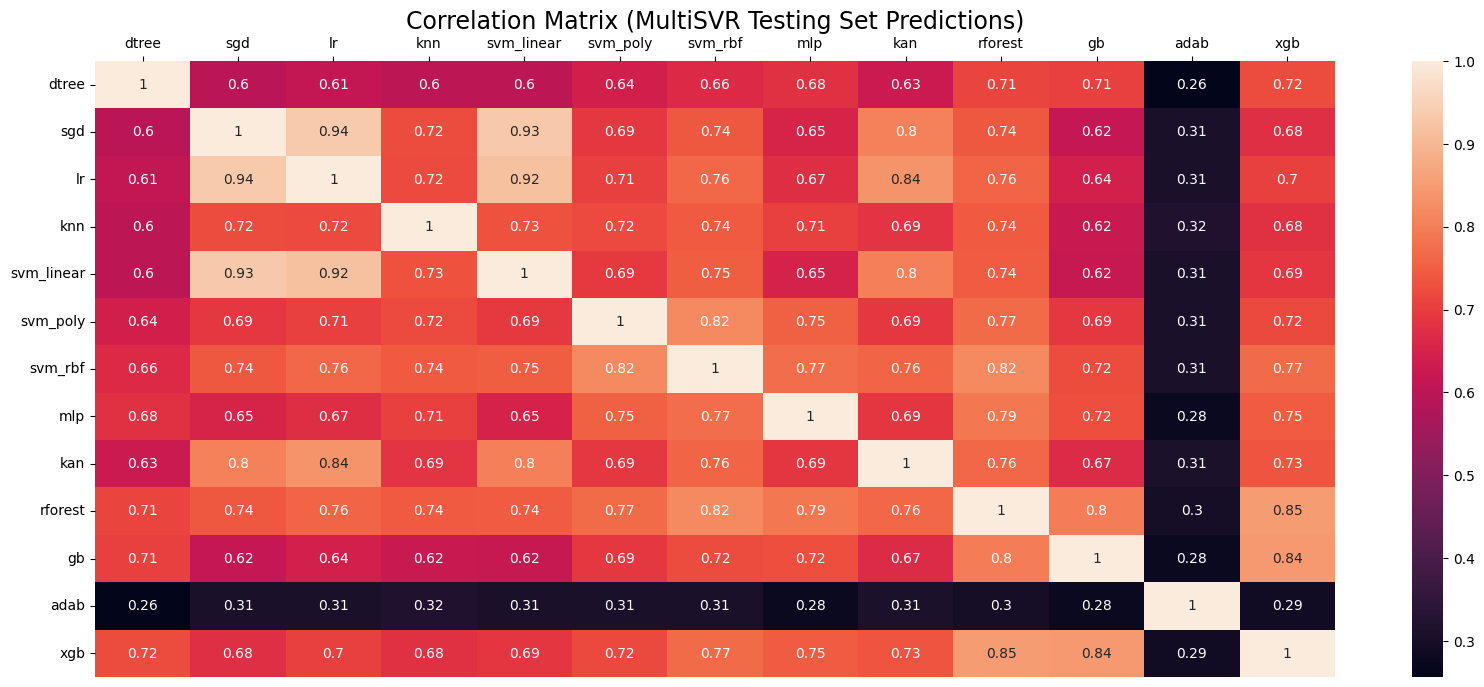

count    78.000000
mean      0.659116
std       0.170540
min       0.256462
25%       0.630875
50%       0.705628
75%       0.751112
max       0.935825
Name: corr, dtype: float64


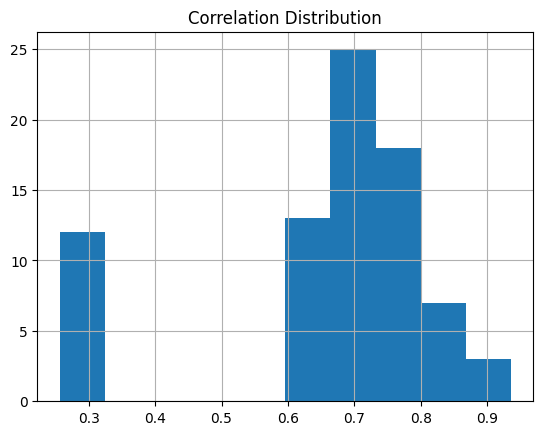

[Saved image "cm_msvrtest.eps"]
[Saved image "cd_msvrtest.eps"]


In [73]:
msvr_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [74]:
groups['msvr_assessor_test'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_test']

[['adab'],
 ['dtree', 'svm_rbf', 'xgb', 'rforest', 'mlp', 'gb'],
 ['lr',
  'svm_poly',
  'svm_rbf',
  'mlp',
  'xgb',
  'kan',
  'rforest',
  'svm_linear',
  'knn',
  'sgd'],
 ['svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'mlp', 'gb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.3310
MAE: 0.4912
NMSE: 13.3157
NMAE: 4.3906


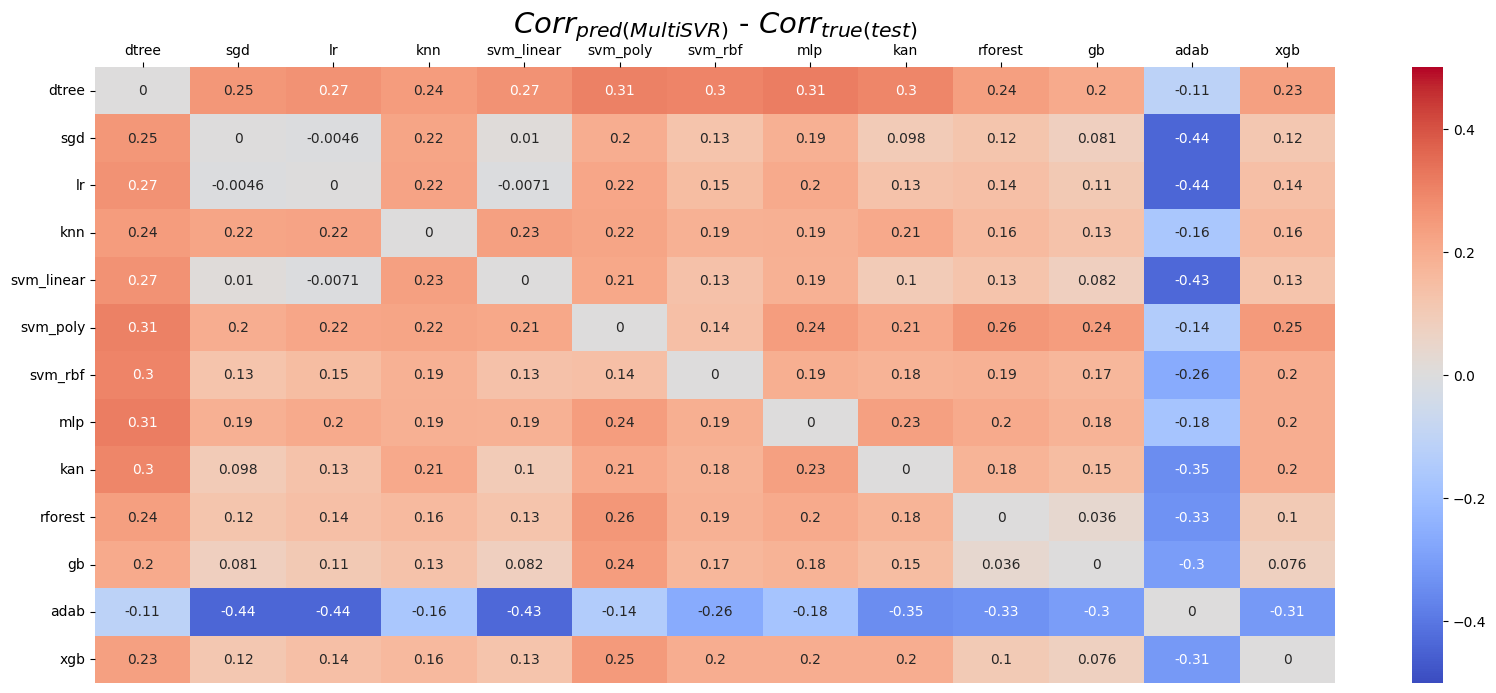

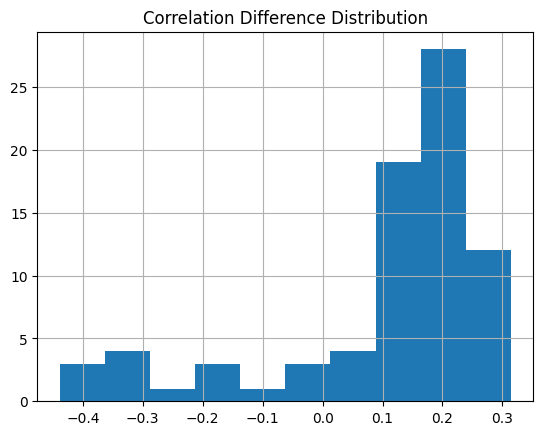

[Saved image "cmd_msvr.eps"]
[Saved image "cdd_msvr.eps"]


In [75]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = msvr_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVR)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output Regressor 
(ST)

In [76]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [77]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-output',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-output',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-output',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0760
NMSE: 0.7130
MAE: 0.1853
NMAE: 0.6912


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   
multi-rforest  0.178776  0.035354  0.041423  0.115596    0.039823  0.071328   
multi-svr      0.178825  0.032716  0.038498  0.107818    0.036907  0.065258   
multi-output   0.178037  0.034438  0.040257  0.116835    0.039294  0.071065   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.062493  0.133824  0.037986  0.046162  0.126113  0.000037   
multi-rforest  0.064260  0.137920  0.039730  0.048880  0.130472  0.000072   
multi-svr      0.059244  0.127654  0.038786  0.046792  0.125909  0.000124   
multi-output   0.063629  0.137116  0.039292  0.048856  0.127702  0.000036   

                    xgb  
regchain       0.089673  
multi-rforest  0.092237  
multi-svr      0.089715  
multi-output   0.091512

#### Análise das correlações

Conjunto de Treinamento:

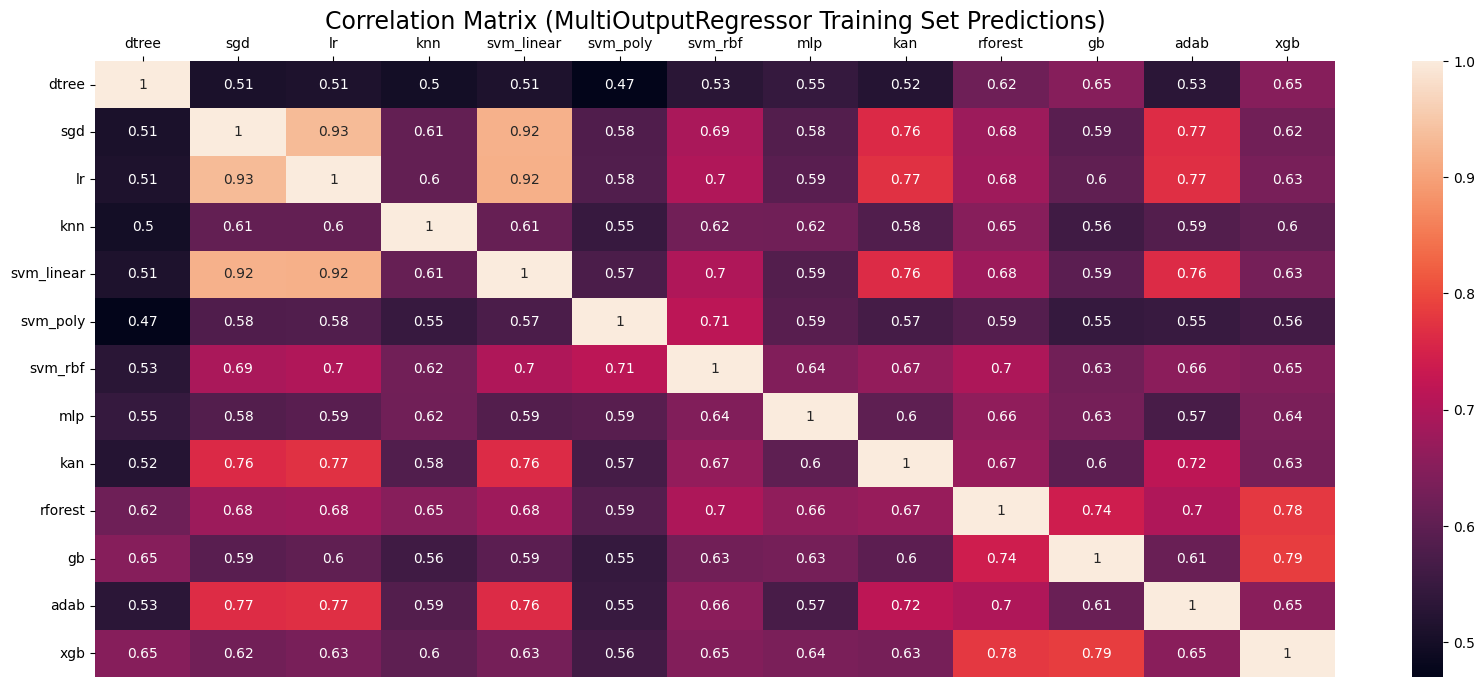

count    78.000000
mean      0.639055
std       0.092821
min       0.470079
25%       0.583844
50%       0.624751
75%       0.679801
max       0.933086
Name: corr, dtype: float64


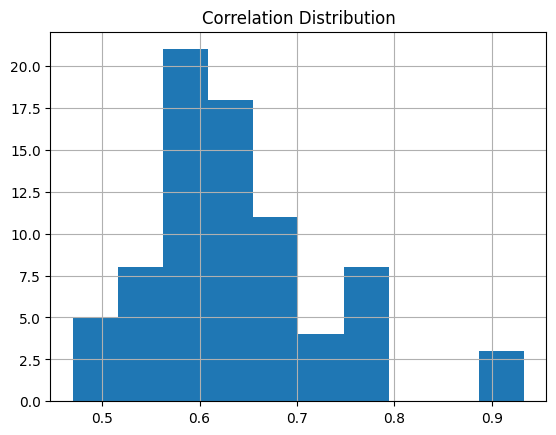

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [78]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [79]:
groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

[['dtree'],
 ['lr', 'svm_rbf', 'adab', 'kan', 'rforest', 'svm_linear', 'sgd'],
 ['adab', 'rforest', 'xgb'],
 ['knn', 'rforest'],
 ['xgb', 'rforest', 'gb'],
 ['mlp', 'rforest'],
 ['svm_poly', 'svm_rbf']]

Conjunto de Teste:

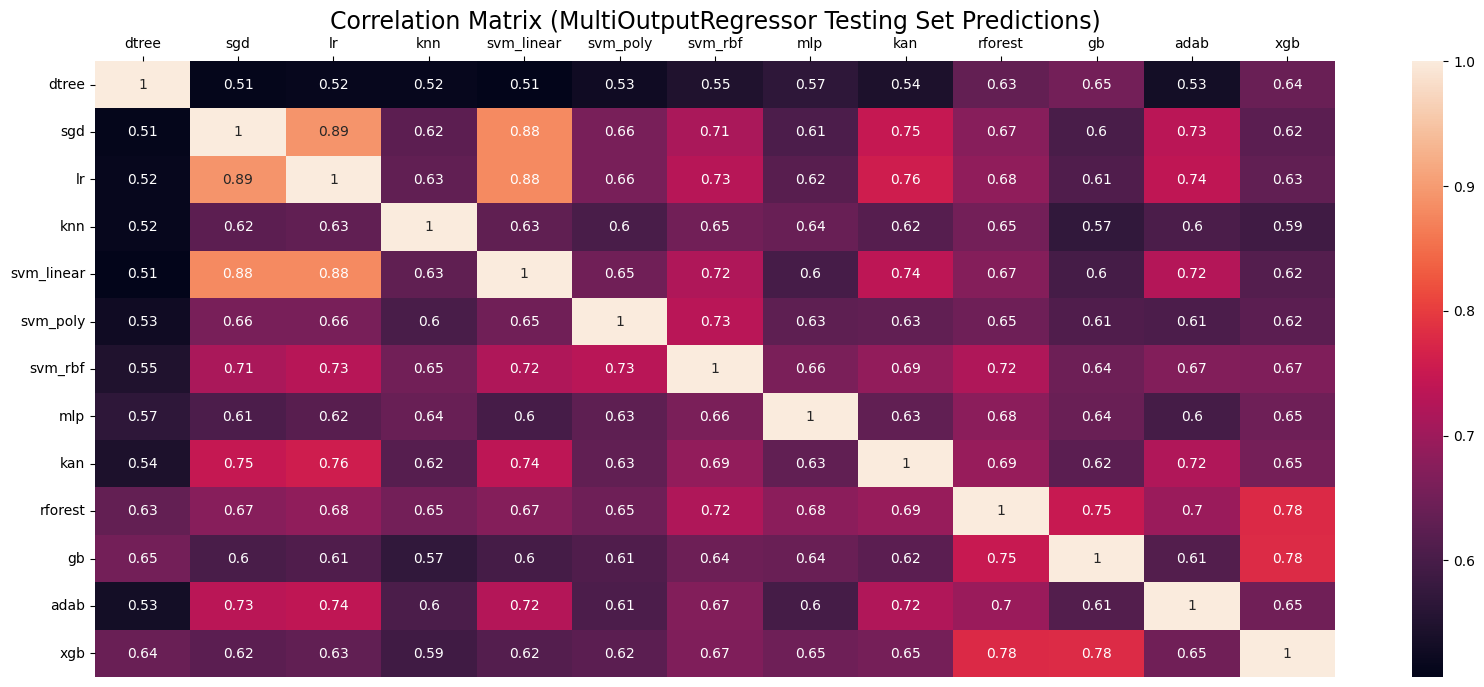

count    78.000000
mean      0.652849
std       0.078289
min       0.506687
25%       0.609717
50%       0.641751
75%       0.691747
max       0.891127
Name: corr, dtype: float64


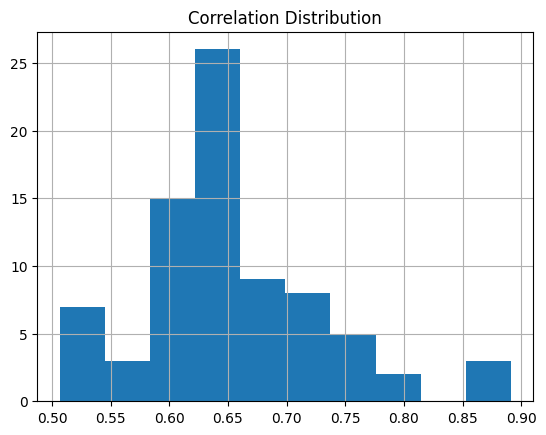

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [80]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [81]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['dtree', 'gb'],
 ['knn', 'rforest'],
 ['xgb', 'rforest', 'gb'],
 ['mlp', 'rforest', 'svm_rbf'],
 ['lr', 'svm_rbf', 'adab', 'kan', 'rforest', 'svm_linear', 'sgd'],
 ['kan', 'rforest', 'svm_rbf', 'xgb'],
 ['svm_poly', 'lr', 'sgd', 'svm_rbf']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.3002
MAE: 0.4970
NMSE: 12.2933
NMAE: 4.5018


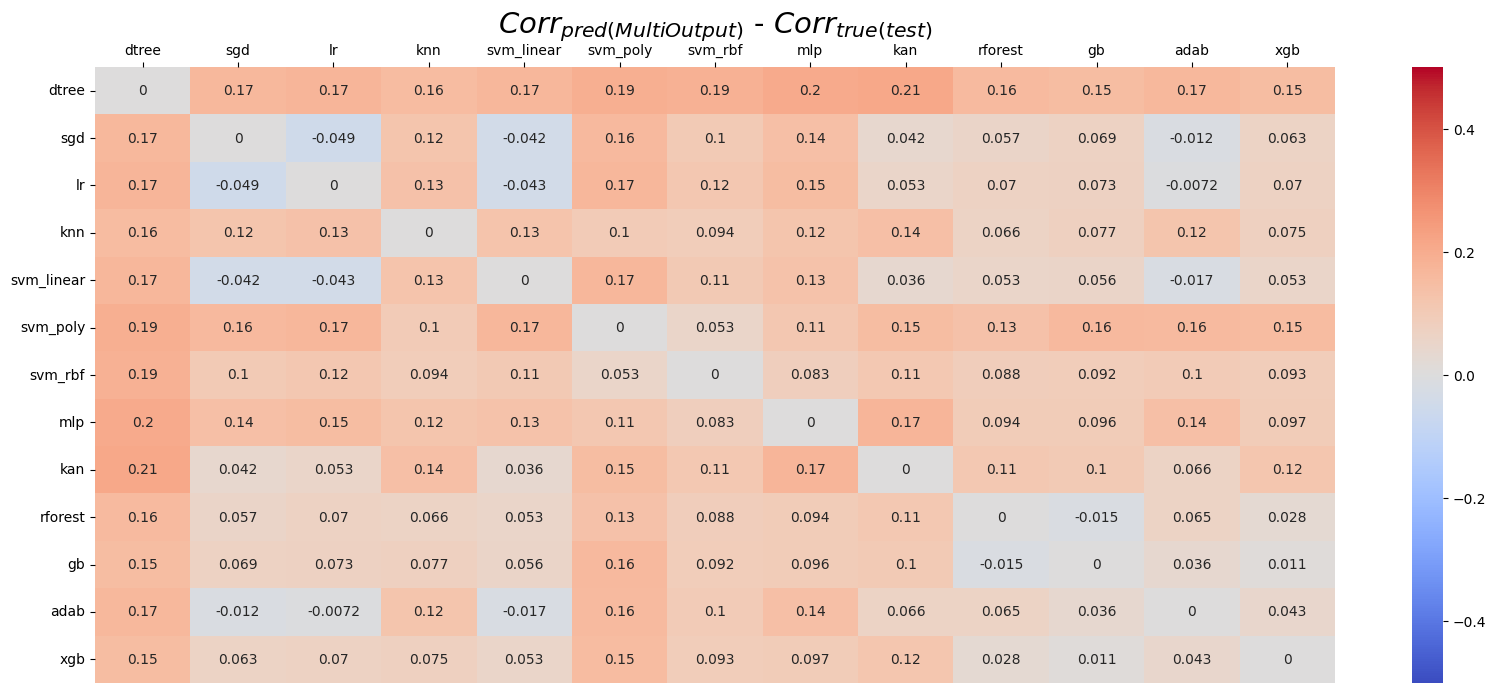

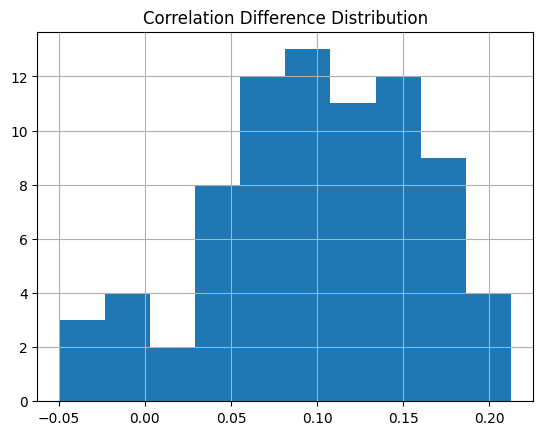

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [82]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Grupais

In [83]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(7) & true_assessor_test(6):
['dtree']
['svm_poly', 'svm_rbf']
['lr', 'adab', 'kan', 'svm_linear', 'sgd']
['xgb', 'rforest', 'gb']
['mlp']
['knn']
Número de grupos em comum: 6


true_assessor_train(7) & regchain_assessor_train(6):
['dtree']
Número de grupos em comum: 1


true_assessor_train(7) & regchain_assessor_test(8):
['dtree']
['knn']
Número de grupos em comum: 2


true_assessor_train(7) & mrf_assessor_train(7):
['svm_poly', 'svm_rbf']
Número de grupos em comum: 1


true_assessor_train(7) & mrf_assessor_test(4):
Número de grupos em comum: 0


true_assessor_train(7) & msvr_assessor_train(4):
Número de grupos em comum: 0


true_assessor_train(7) & msvr_assessor_test(4):
Número de grupos em comum: 0


true_assessor_train(7) & mor_assessor_train(7):
['dtree']
['svm_poly', 'svm_rbf']
['xgb', 'rforest', 'gb']
Número de grupos em comum: 3


true_assessor_train(7) & mor_assessor_test(7):
['xgb', 'rforest', 'gb']
Número de grupos em comum: 1


true_assessor_test(6) & reg

In [84]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['svm_poly', 'svm_rbf']
total: 0.6719571475336419

['lr', 'adab', 'kan', 'svm_linear', 'sgd']
total: 0.7817609690841333

['adab', 'rforest']
total: 0.6577309981567213

['xgb', 'rforest', 'gb']
total: 0.764215204507198



### Regressor Chain

In [85]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [86]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0759
MAE: 0.1870
NMSE: 0.7103
NMAE: 0.6980


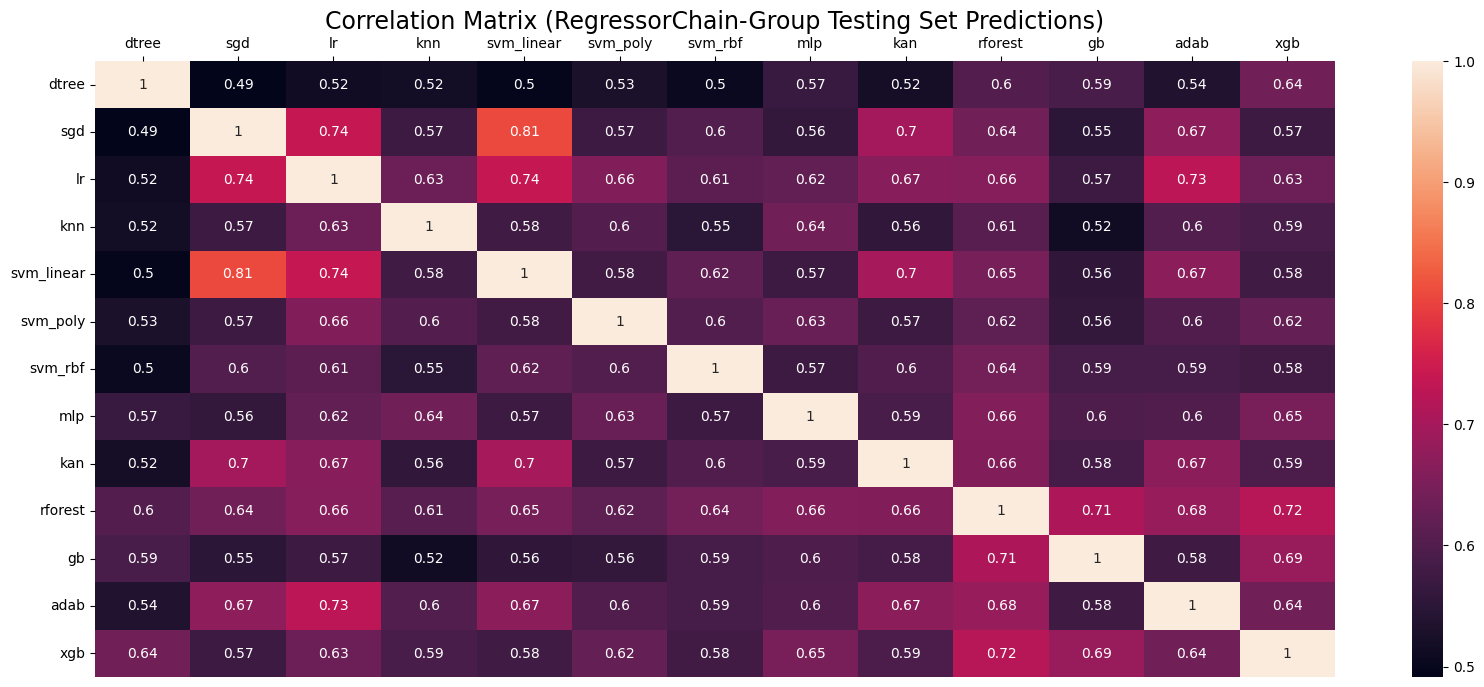

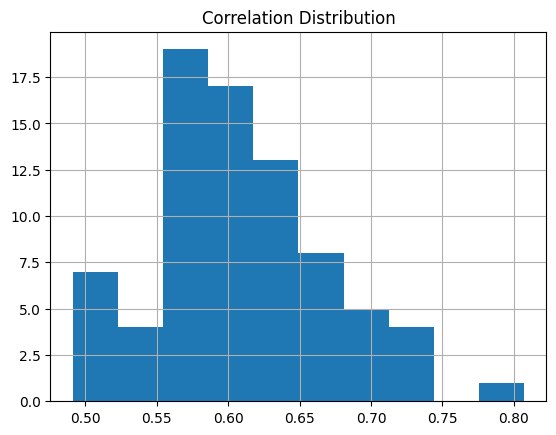

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.3466
MAE: 0.5371
NMSE: 14.1677
NMAE: 4.8695


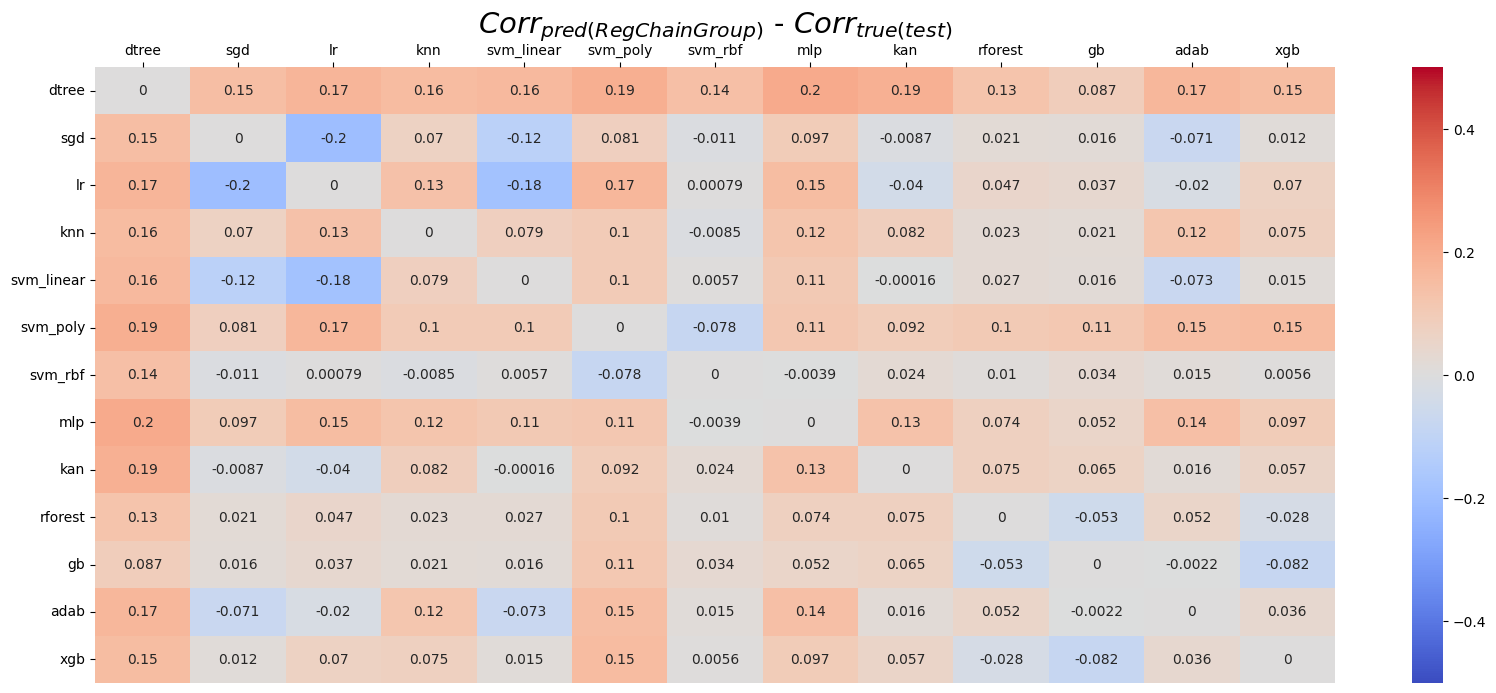

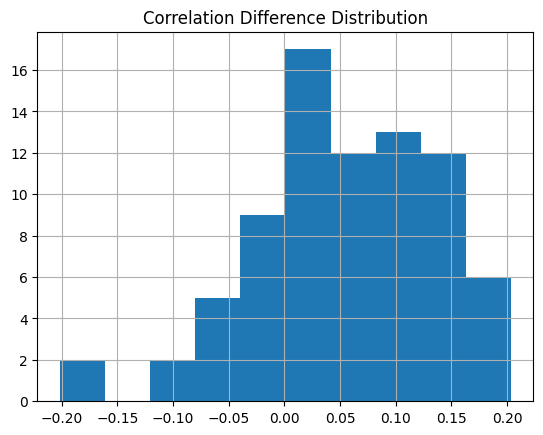

[['dtree'], ['lr', 'svm_poly'], ['lr', 'adab', 'kan', 'svm_linear', 'sgd'], ['lr', 'adab', 'rforest', 'kan'], ['svm_rbf'], ['xgb', 'rforest', 'gb'], ['mlp', 'rforest'], ['knn']]
[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [87]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['regchain(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['regchain(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['regchain(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['regchain_group_test'] = group_search(regchainGroups_corrls, MIN_SCORE)
print(groups['regchain_group_test'])

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Output SVR

In [88]:
msvr4groups = []

for g in groups['true_assessor_train']:
    msvr4groups.append(MSVR())
    msvr4groups[-1].fit(Xb_test_norm, np.asarray(ya_train[g]))

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:63: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u
c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:63: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


In [89]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = msvr4groups[i].predict(Xa_test_norm)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0789
MAE: 0.1944
NMSE: 0.7840
NMAE: 0.8108


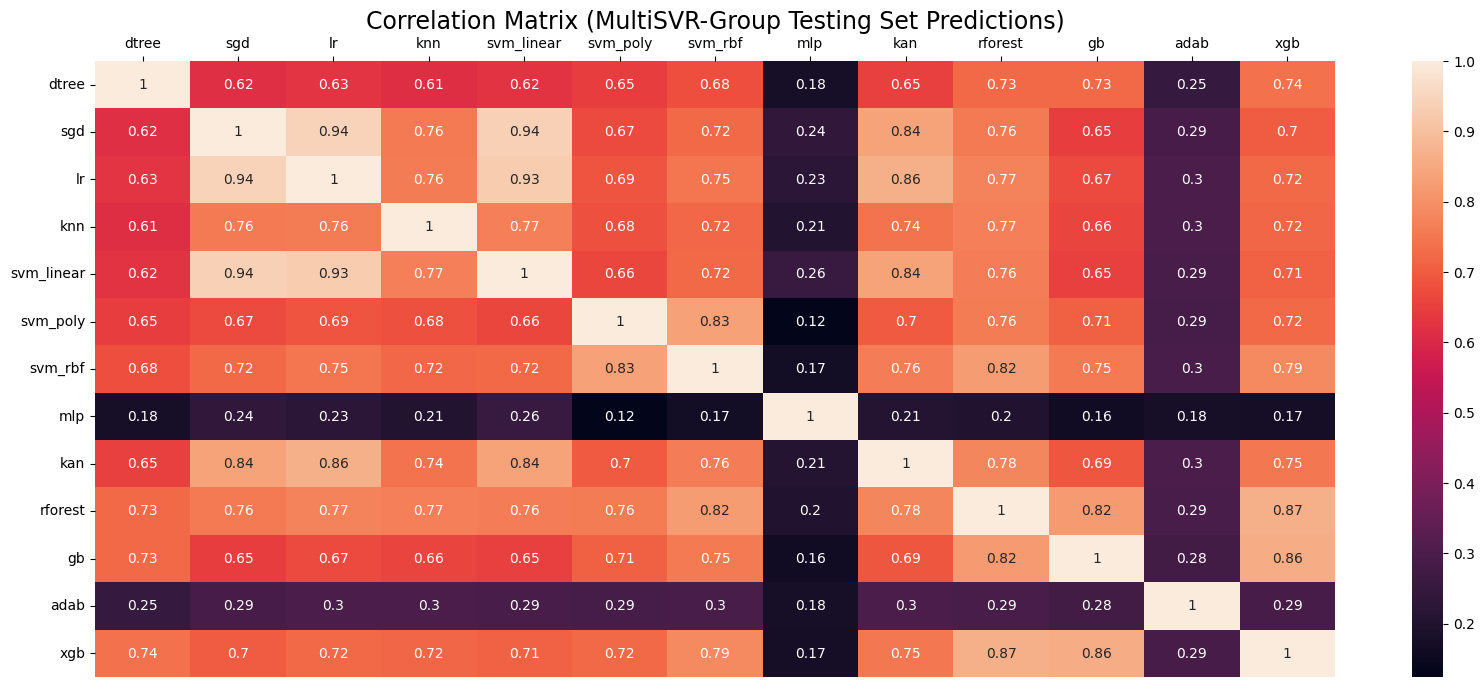

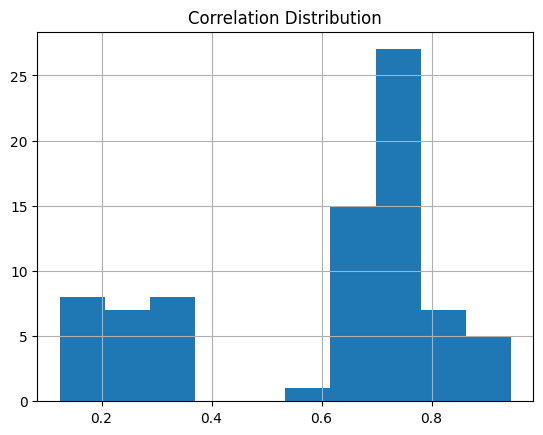

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4033
MAE: 0.5518
NMSE: 16.6418
NMAE: 5.0277


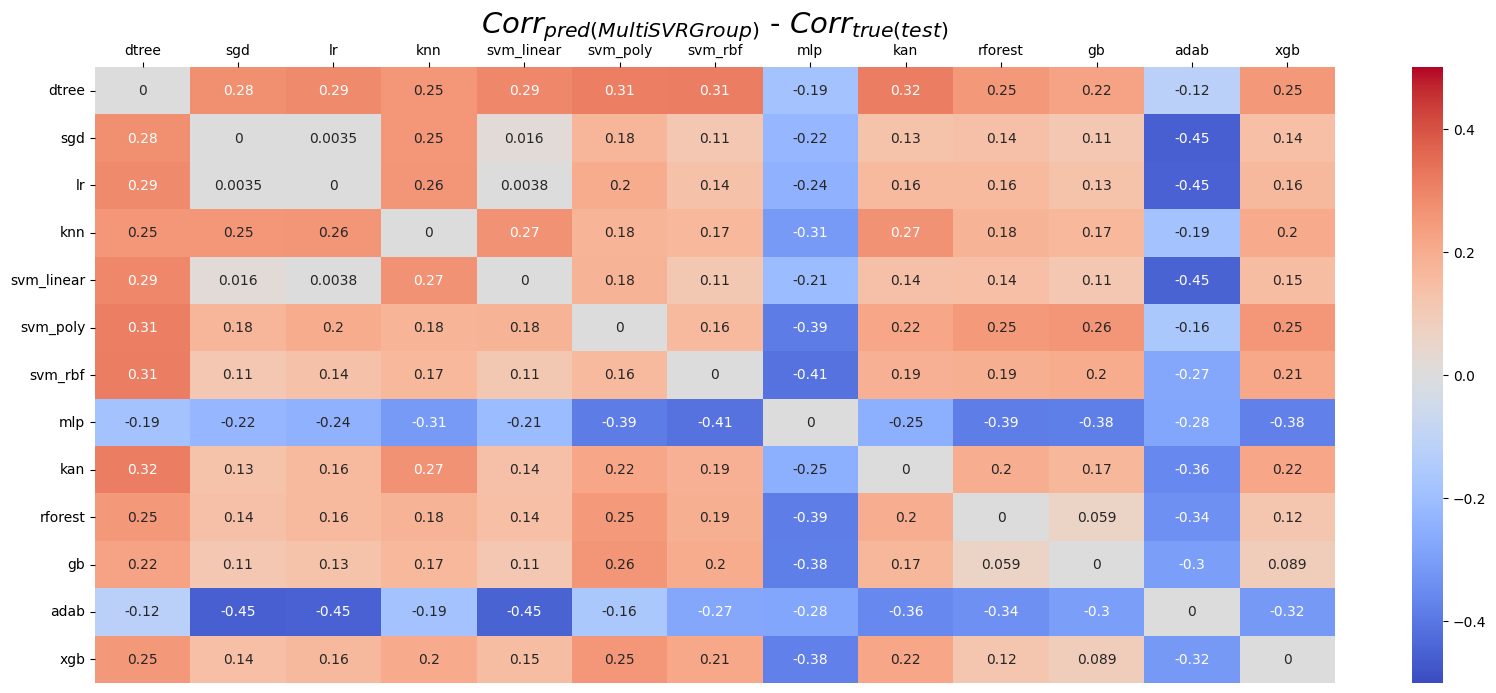

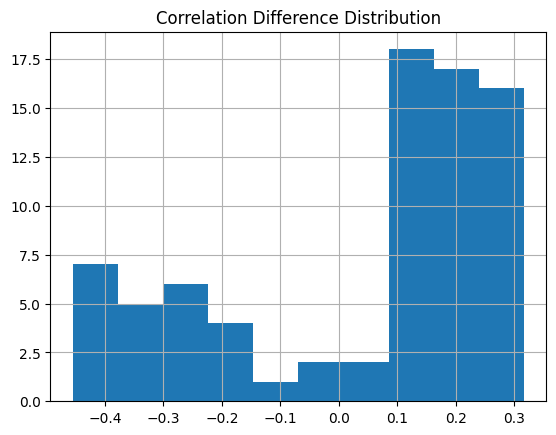

[['mlp'], ['adab'], ['dtree', 'svm_rbf', 'xgb', 'rforest', 'gb'], ['lr', 'svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'svm_linear', 'knn', 'sgd'], ['lr', 'svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'svm_linear', 'knn', 'gb']]
[Saved image "cm_msvrgtest.eps"]
[Saved image "cd_msvrgtest.eps"]
[Saved image "cmd_msvrg.eps"]
[Saved image "cdd_msvrg.eps"]


In [90]:
msvrGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-svr(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-svr(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-svr(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-svr(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(msvrGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(msvrGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = msvrGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVRGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['msvr_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)
print(groups['msvr_group_test'])

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Target Random Forest Regressor

In [91]:
mrf4groups = []

for g in groups['true_assessor_train']:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train[g])
    mrf4groups.append(model)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [92]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mrf4groups[i].predict(Xa_test).reshape(-1,1) if len(g) == 1 else mrf4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0762
MAE: 0.1857
NMSE: 0.7260
NMAE: 0.7025


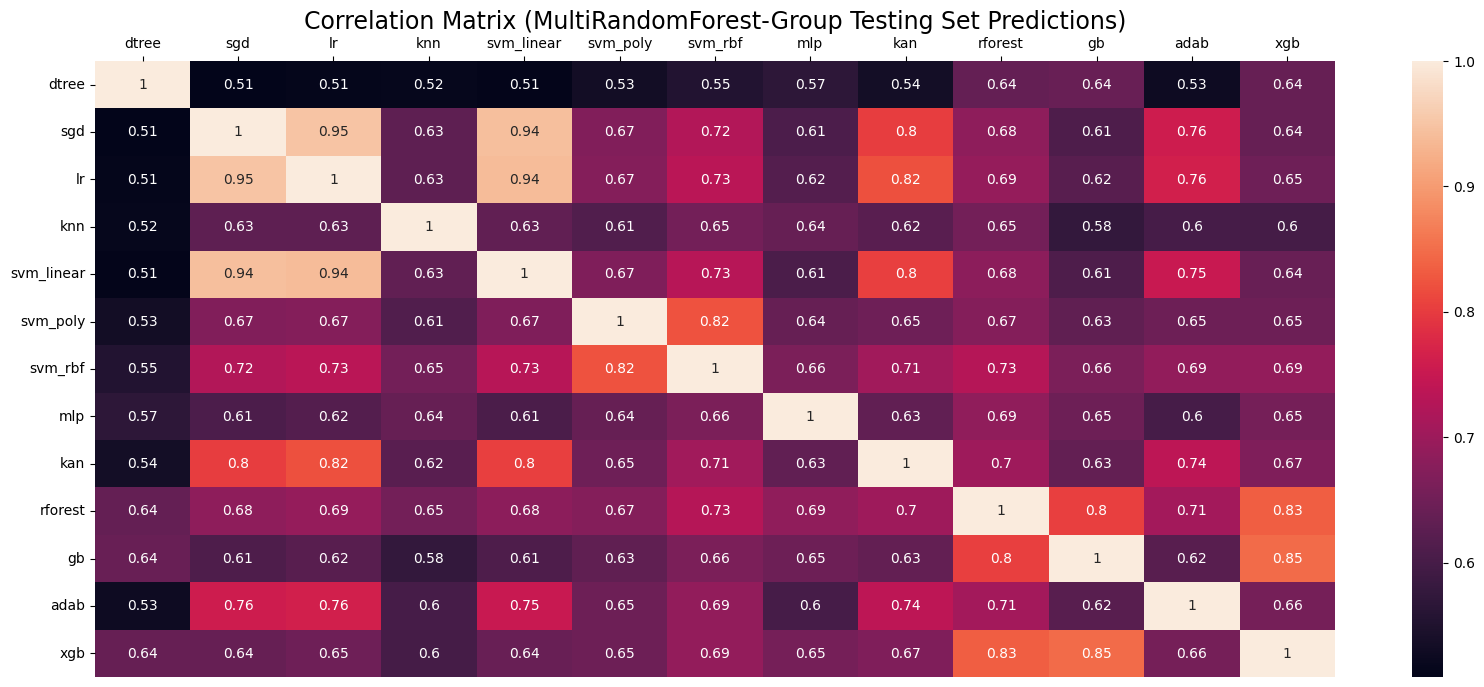

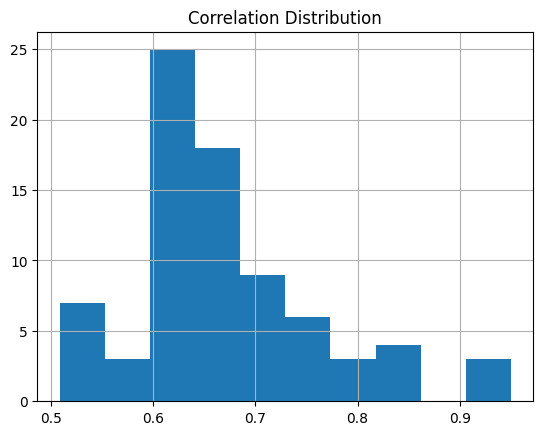

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2824
MAE: 0.4823
NMSE: 11.5912
NMAE: 4.3732


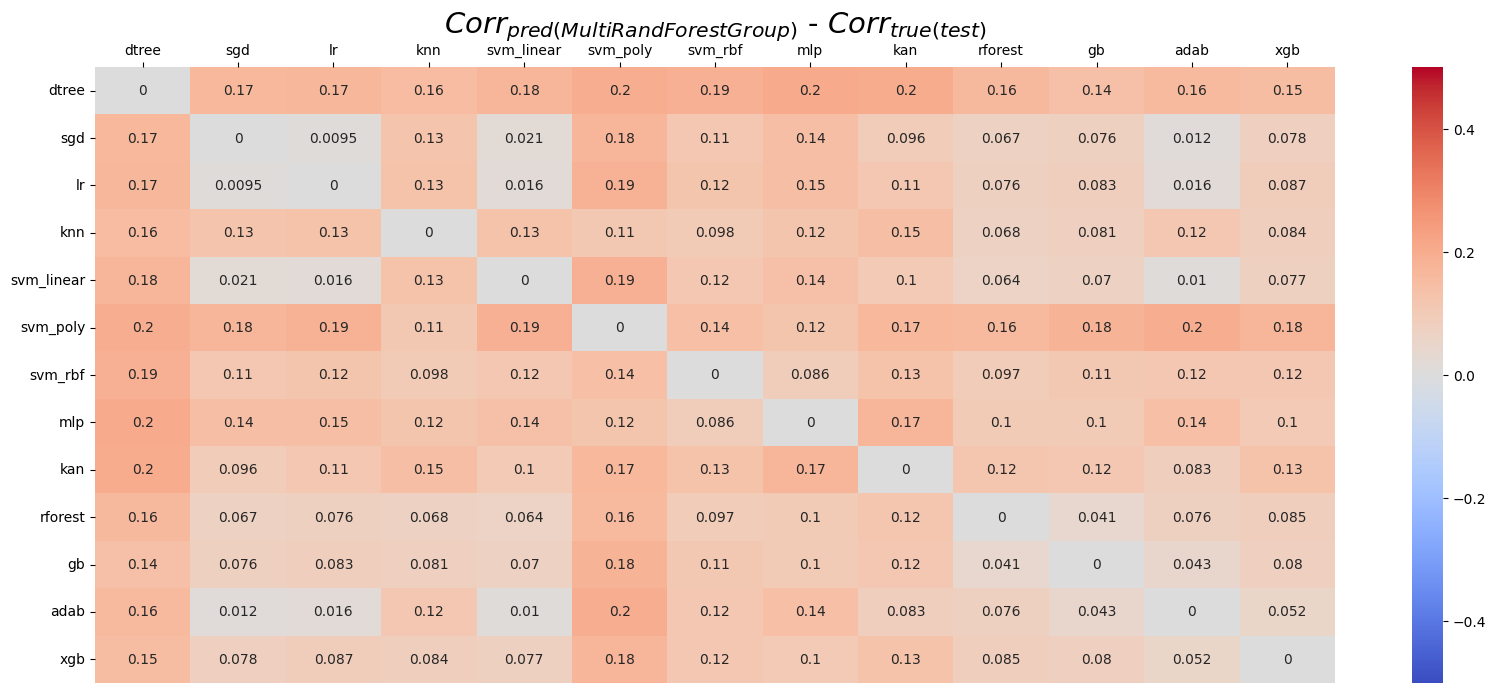

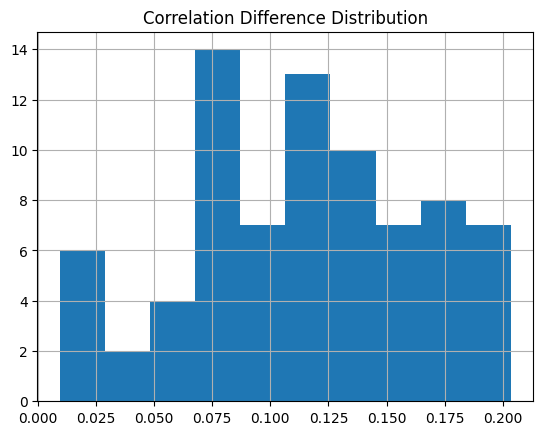

[['mlp'], ['adab'], ['dtree', 'svm_rbf', 'xgb', 'rforest', 'gb'], ['lr', 'svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'svm_linear', 'knn', 'sgd'], ['lr', 'svm_poly', 'svm_rbf', 'xgb', 'kan', 'rforest', 'svm_linear', 'knn', 'gb']]
[Saved image "cm_mrfgtest.eps"]
[Saved image "cd_mrfgtest.eps"]
[Saved image "cmd_mrfg.eps"]
[Saved image "cdd_mrfg.eps"]


In [94]:
morGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-rforest(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-rforest(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(morGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(morGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandForestGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['mrf_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)
print(groups['mrf_group_test'])

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

In [95]:
keys = list(groups.keys())
OBJV = len(groups['true_assessor_test'])
for i in range(len(keys)):
    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups['true_assessor_test']):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

regchain_assessor_test(8) & true_assessor_test(6):
['dtree']
['knn']
Número de grupos em comum: 2


mrf_assessor_test(4) & true_assessor_test(6):
Número de grupos em comum: 0


msvr_assessor_test(4) & true_assessor_test(6):
Número de grupos em comum: 0


mor_assessor_test(7) & true_assessor_test(6):
['xgb', 'rforest', 'gb']
Número de grupos em comum: 1


regchain_group_test(8) & true_assessor_test(6):
['dtree']
['lr', 'adab', 'kan', 'svm_linear', 'sgd']
['xgb', 'rforest', 'gb']
['knn']
Número de grupos em comum: 4


msvr_group_test(5) & true_assessor_test(6):
['mlp']
Número de grupos em comum: 1


mrf_group_test(5) & true_assessor_test(6):
['mlp']
Número de grupos em comum: 1




## Análises

In [96]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmae_df, 'NMAE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE       MAE      NMSE      NMAE
0               regchain  dtree  0.178037  0.334889  0.891180  0.836084
1          multi-rforest  dtree  0.178776  0.337186  0.894878  0.841818
2              multi-svr  dtree  0.178825  0.355766  0.895124  0.888205
3           multi-output  dtree  0.178037  0.334889  0.891180  0.836084
4        regchain(group)  dtree  0.178037  0.334889  0.891180  0.836084
..                   ...    ...       ...       ...       ...       ...
86             multi-svr    xgb  0.089715  0.229379  0.781467  0.801770
87          multi-output    xgb  0.091512  0.215301  0.797117  0.752561
88       regchain(group)    xgb  0.091512  0.215301  0.797117  0.752561
89      multi-svr(group)    xgb  0.089431  0.226041  0.778994  0.790101
90  multi-rforest(group)    xgb  0.092643  0.217333  0.806967  0.759663

[91 rows x 6 columns]

In [126]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["MSE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-svr           7
regchain(group)     2
regchain            2
multi-svr(group)    2
Name: count, dtype: int64

In [127]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["MAE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-output            6
regchain(group)         2
multi-svr(group)        2
regchain                1
multi-rforest(group)    1
multi-svr               1
Name: count, dtype: int64

In [129]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["NMSE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-svr           7
regchain(group)     2
regchain            2
multi-svr(group)    2
Name: count, dtype: int64

In [130]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["NMAE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict
best_assessors['assessor_type'].value_counts()

assessor_type
multi-output            6
regchain(group)         2
multi-svr(group)        2
regchain                1
multi-rforest(group)    1
multi-svr               1
Name: count, dtype: int64

In [ ]:
for a in metrics_df.assessor_type.unique():
    for m in metrics_df.model.unique():
        pass

assessor_type  model       MSE       MAE      NMSE      NMAE
0               regchain  dtree  0.178037  0.334889  0.891180  0.836084
1          multi-rforest  dtree  0.178776  0.337186  0.894878  0.841818
2              multi-svr  dtree  0.178825  0.355766  0.895124  0.888205
3           multi-output  dtree  0.178037  0.334889  0.891180  0.836084
4        regchain(group)  dtree  0.178037  0.334889  0.891180  0.836084
..                   ...    ...       ...       ...       ...       ...
86             multi-svr    xgb  0.089715  0.229379  0.781467  0.801770
87          multi-output    xgb  0.091512  0.215301  0.797117  0.752561
88       regchain(group)    xgb  0.091512  0.215301  0.797117  0.752561
89      multi-svr(group)    xgb  0.089431  0.226041  0.778994  0.790101
90  multi-rforest(group)    xgb  0.092643  0.217333  0.806967  0.759663

[91 rows x 6 columns]

In [ ]:
metrics_df.loc[metrics_df['model']=='dtree','MSE']

0.17803692271748764

In [103]:
teste.to_latex(f'teste.tex')

In [98]:
class_palette = sns.color_palette()[:7]

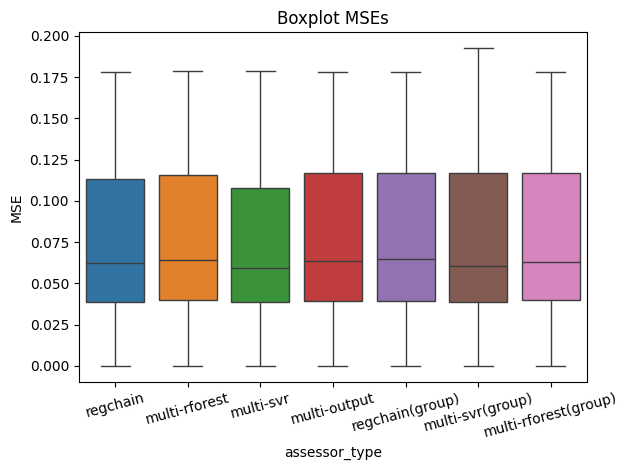

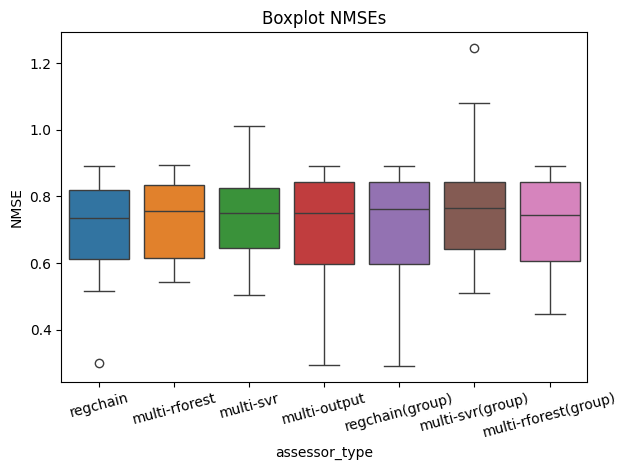

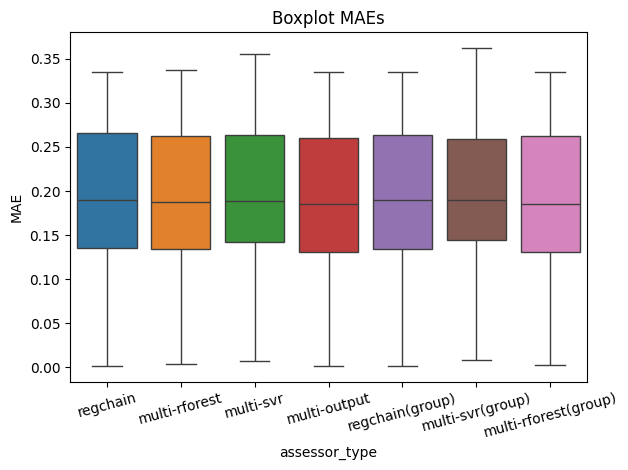

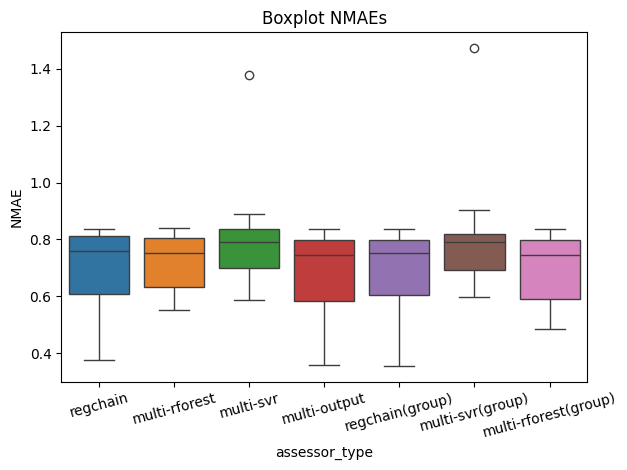

In [99]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

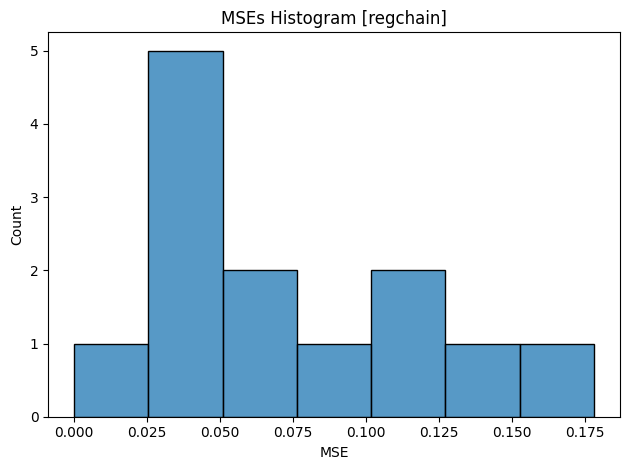

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


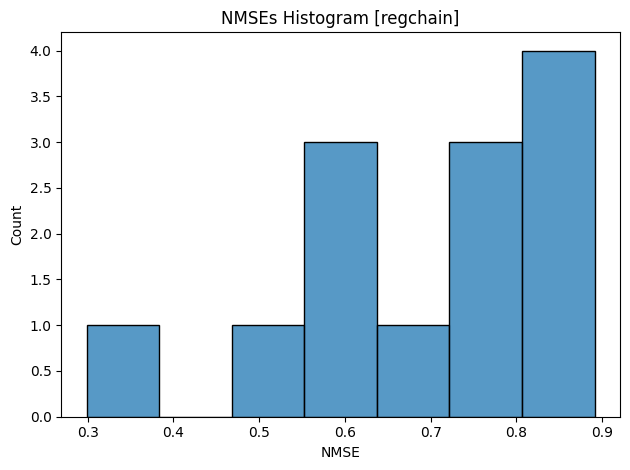

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


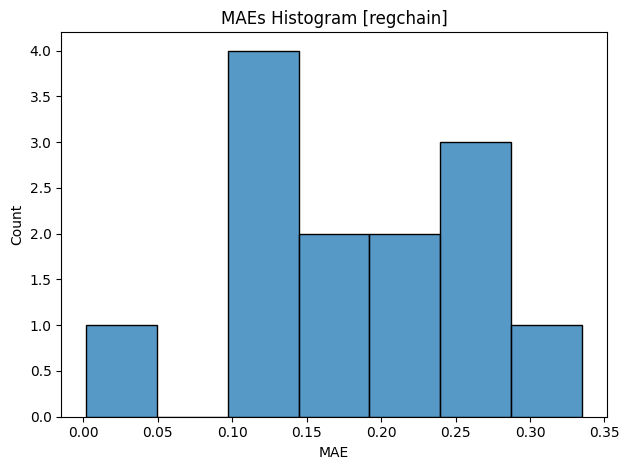

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


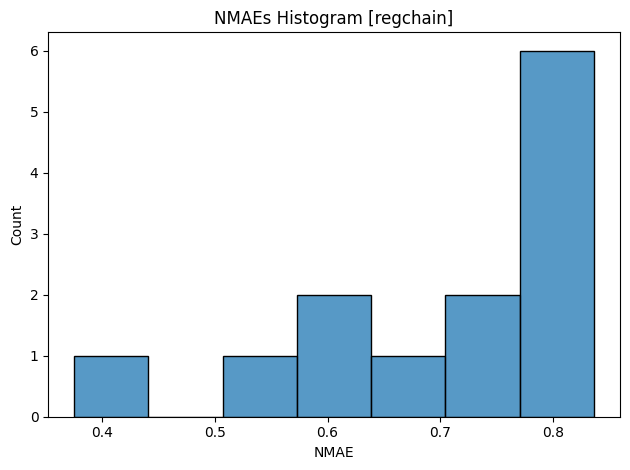

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


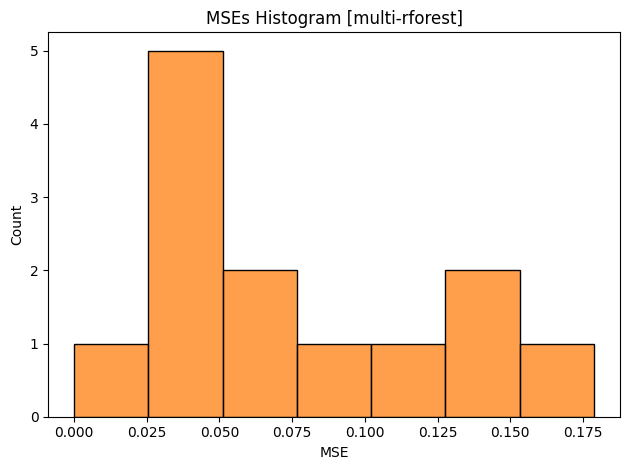

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


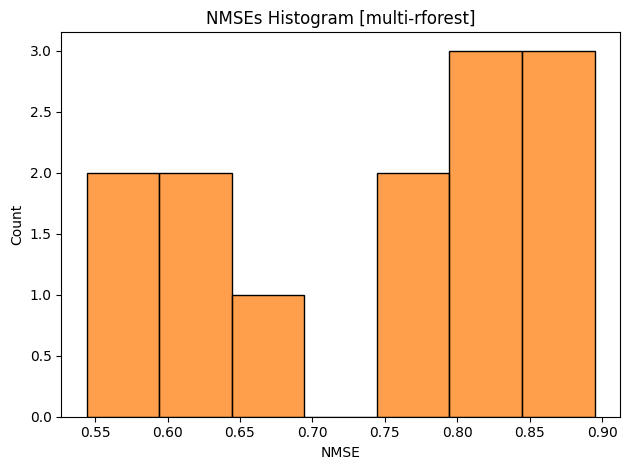

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


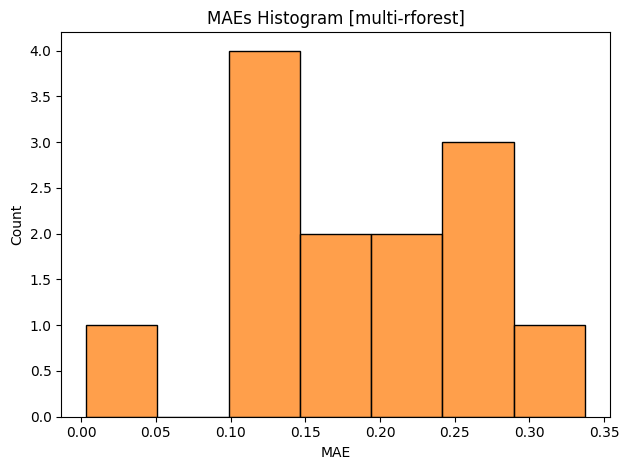

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


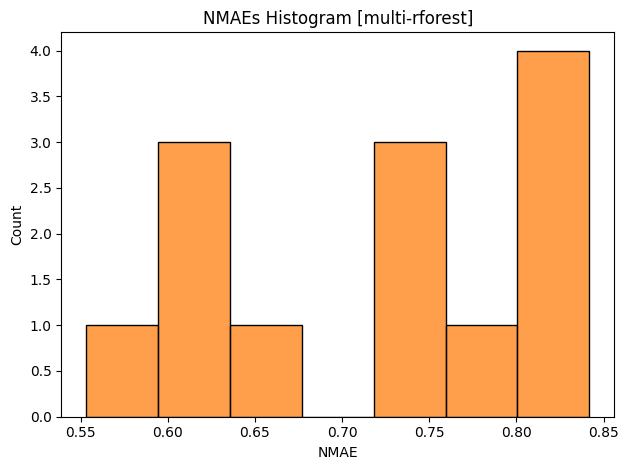

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


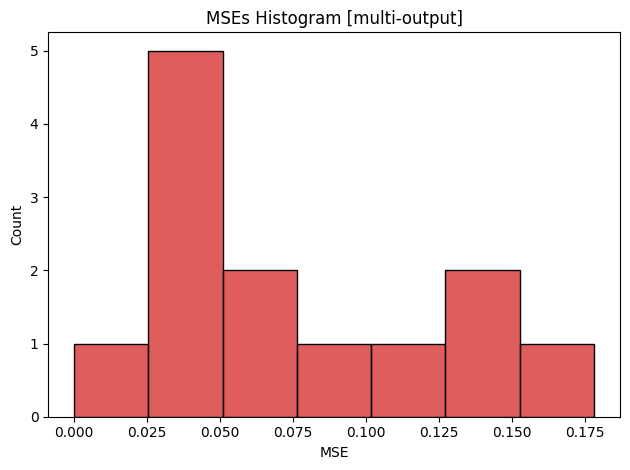

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


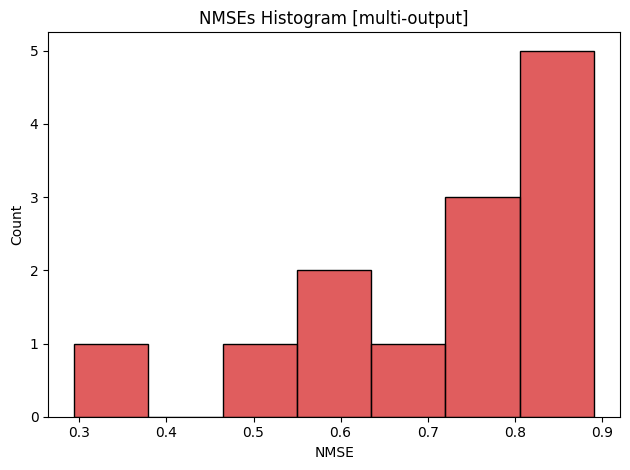

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


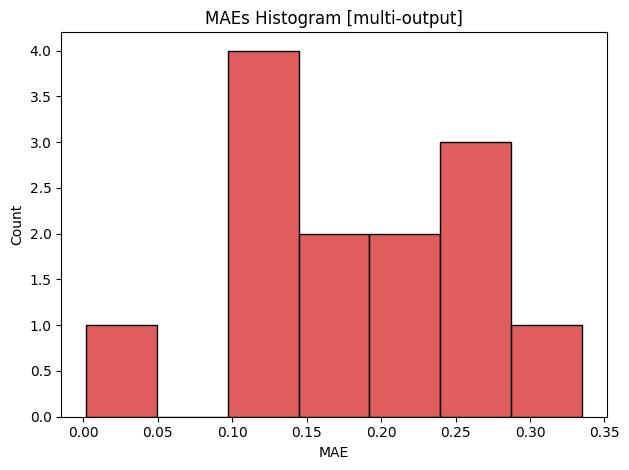

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


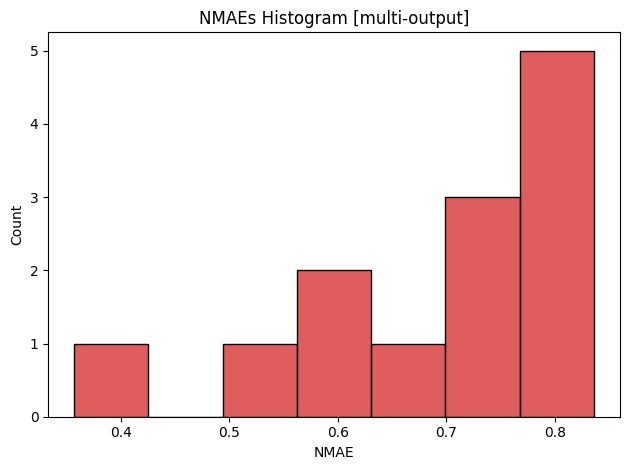

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


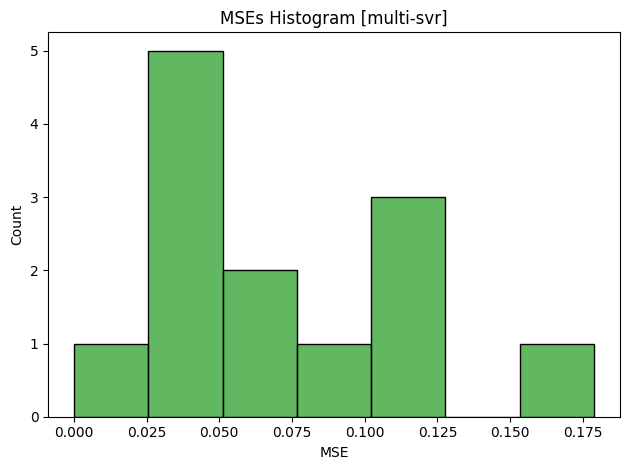

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


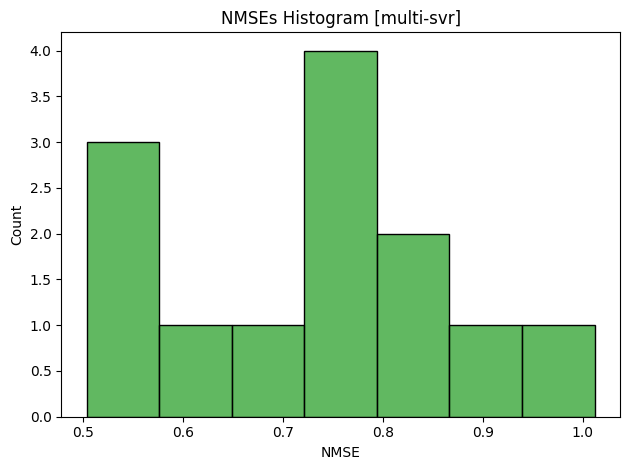

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


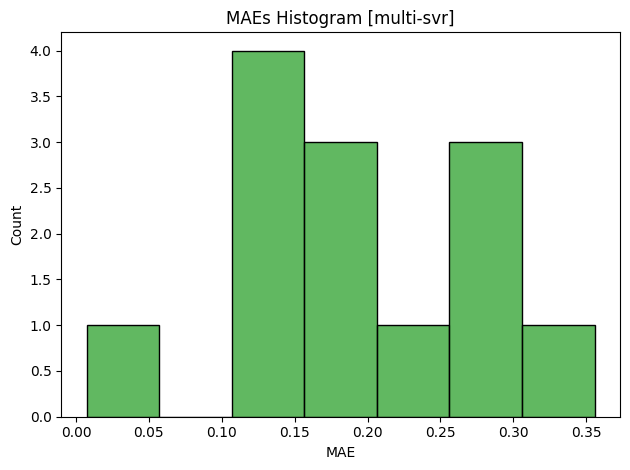

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


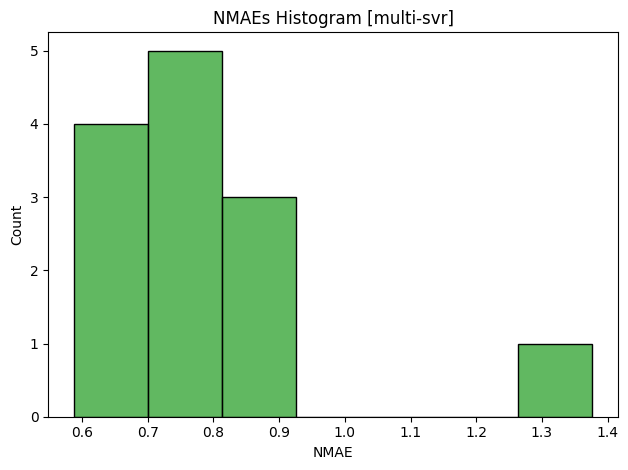

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


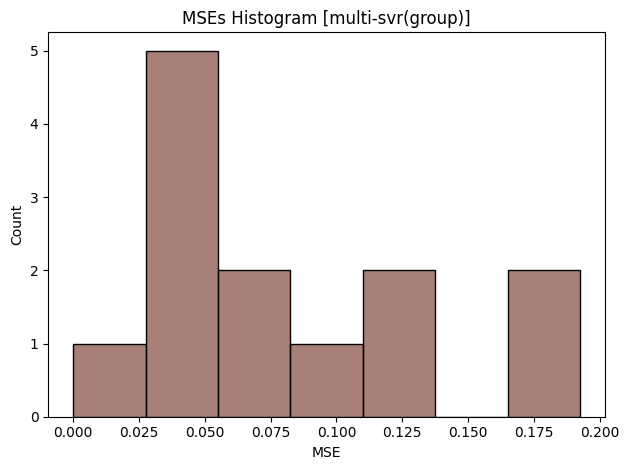

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


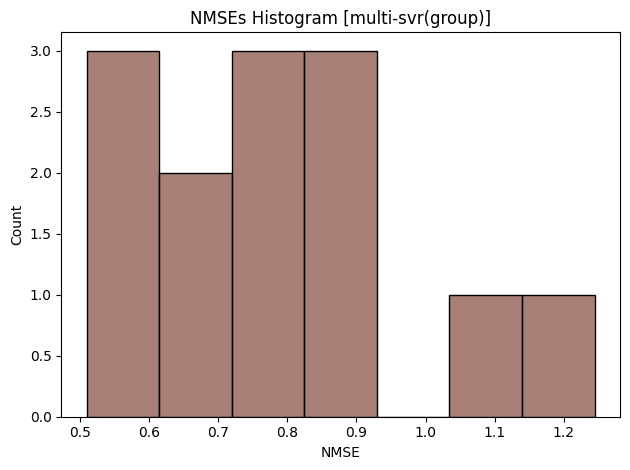

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


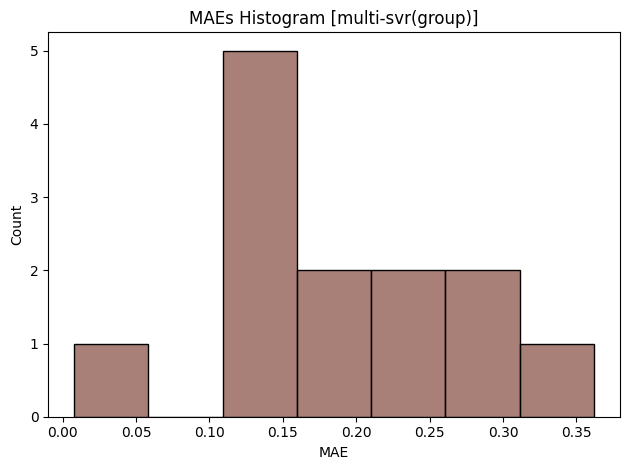

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


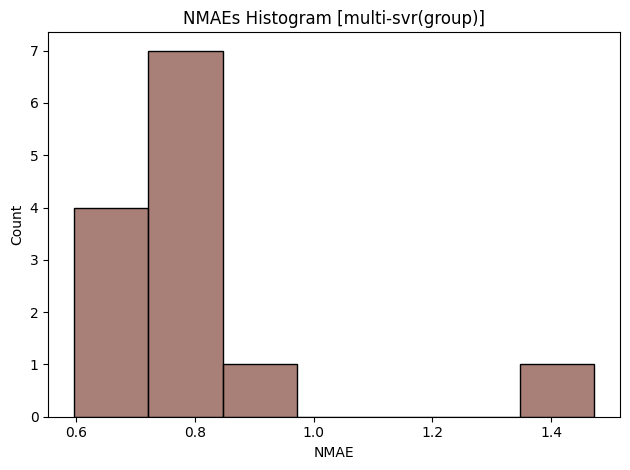

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


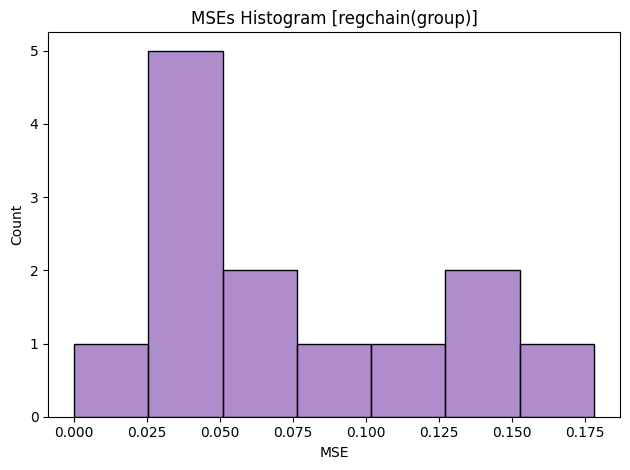

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


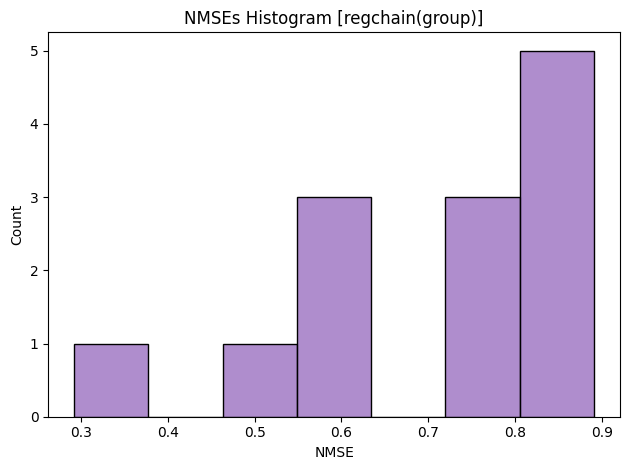

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


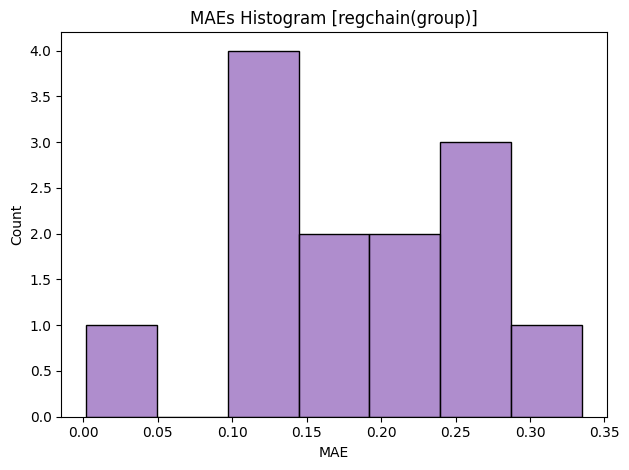

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


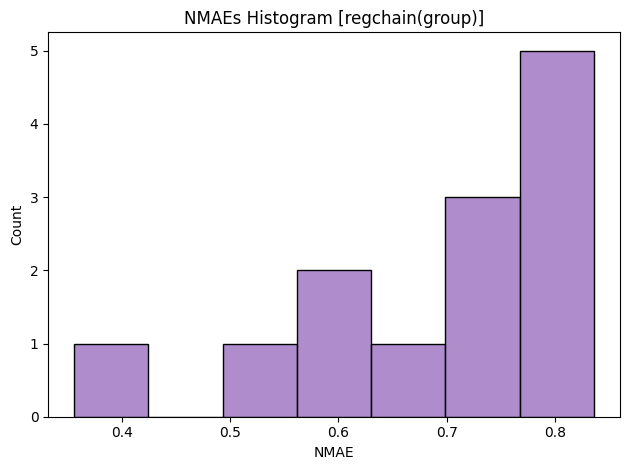

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


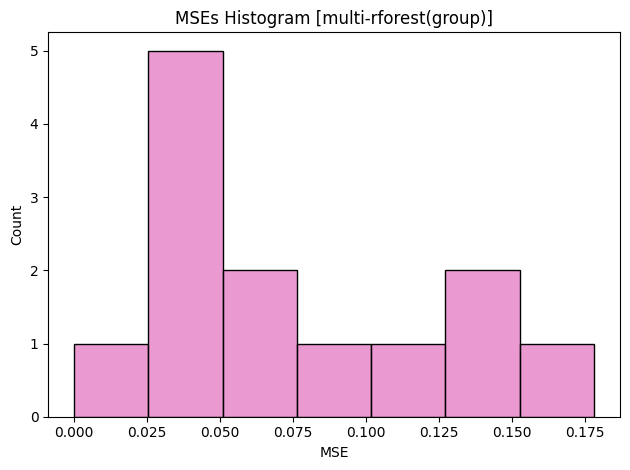

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


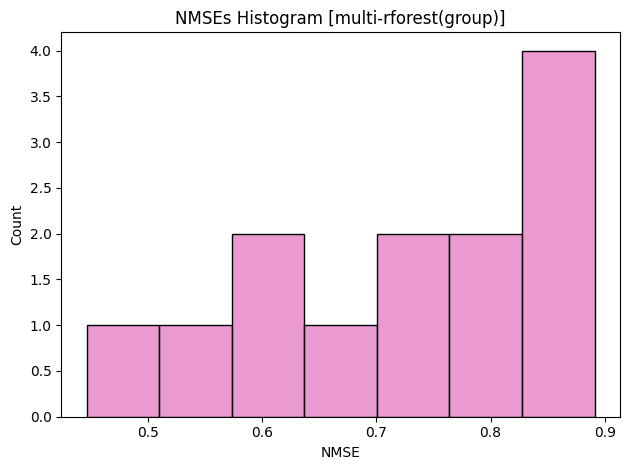

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


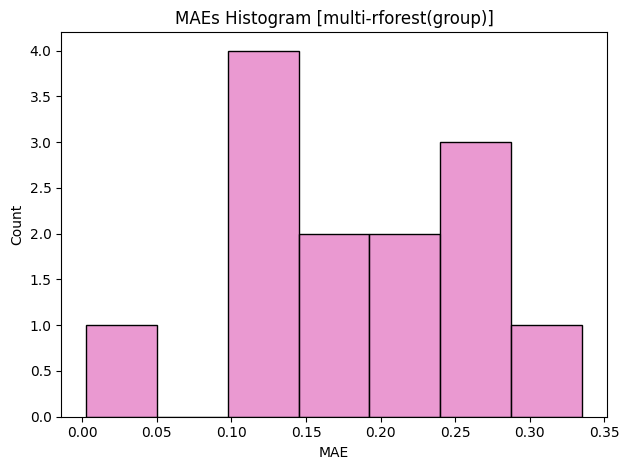

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


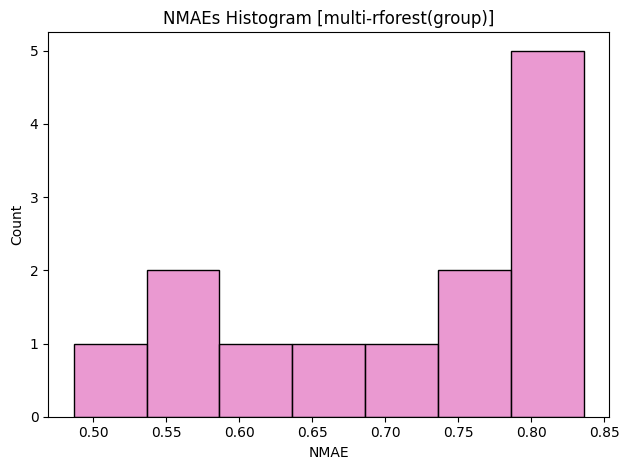

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [100]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-rforest': {'color': class_palette[1], 'code': 'mrf'},
         'multi-output': {'color': class_palette[3], 'code': 'mor'},
         'multi-svr': {'color': class_palette[2], 'code': 'msvr'},
         'multi-svr(group)': {'color': class_palette[-2], 'code': 'msvrg'},
         'regchain(group)': {'color': class_palette[-3], 'code': 'rcg'},
         'multi-rforest(group)': {'color': class_palette[-1], 'code': 'mrfg'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

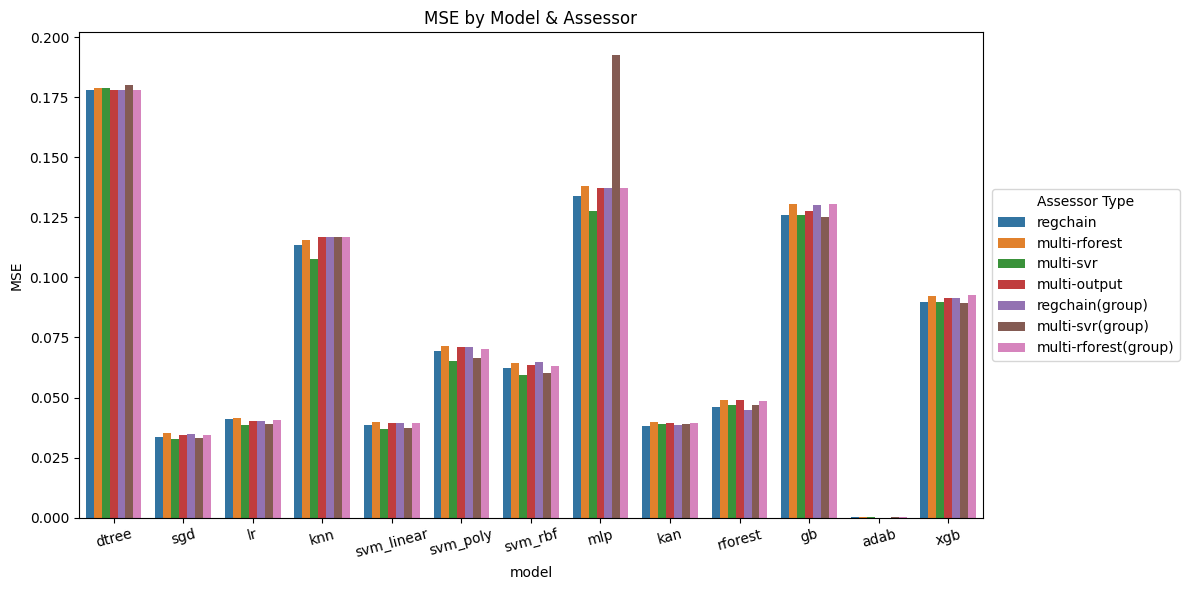

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


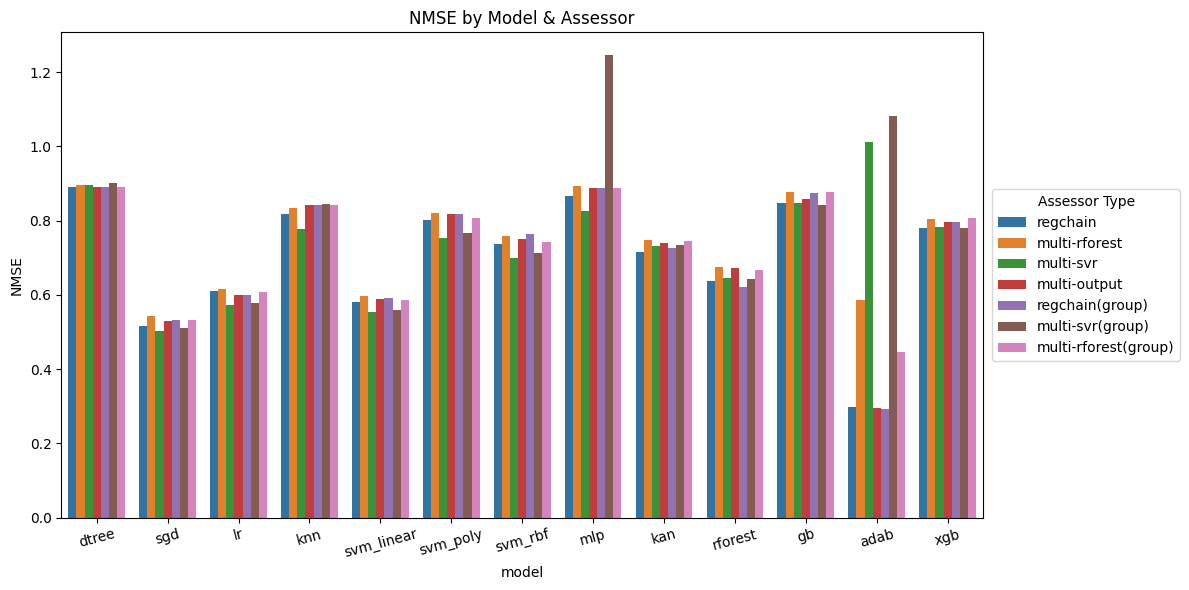

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


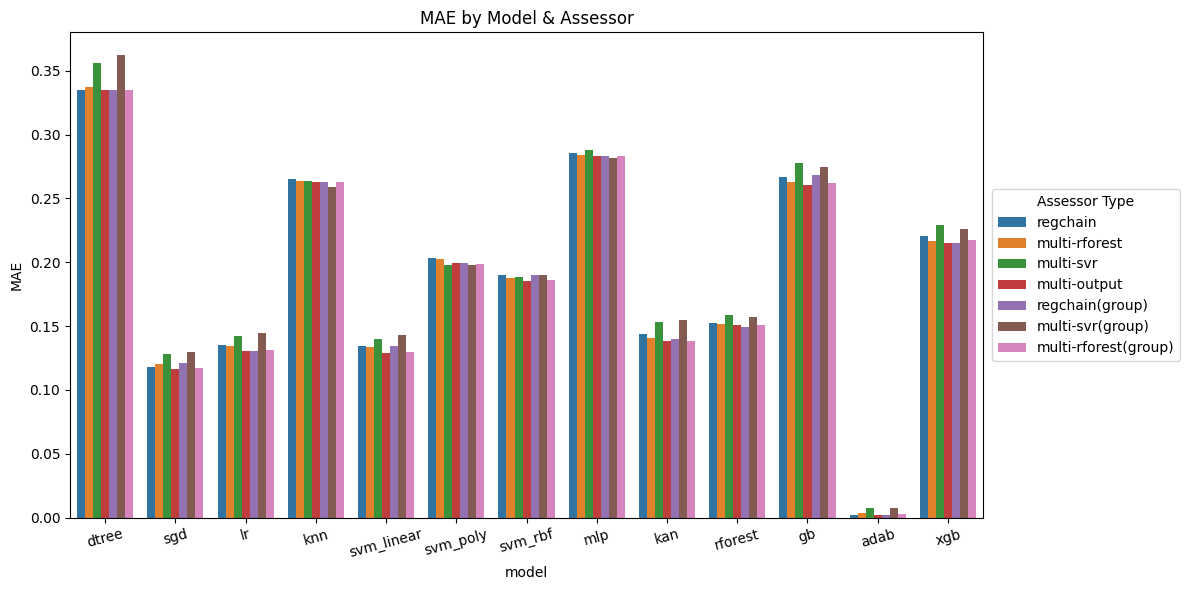

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


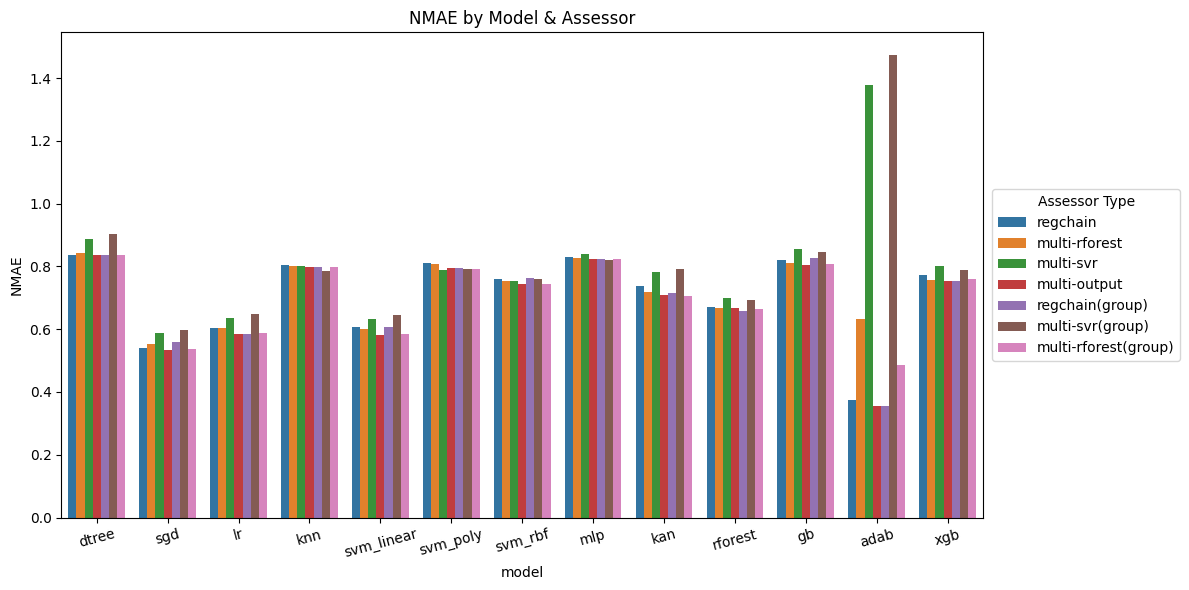

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [101]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)